In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import os
import torch
import torch.nn as nn
import torchvision.models as models

In [3]:
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Use ResNet-18 as the feature extractor (encoder)
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Fully connected layers for further encoding
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # Fully connected layers for decoding
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)

        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(512, 128*128*3),
            nn.Tanh()  # or nn.Sigmoid() depending on the input normalization
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the encoder

        # Further encode the features
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))

        # Decode the features
        x = nn.ReLU()(self.fc4(x))
        x = nn.ReLU()(self.fc5(x))
        x = nn.ReLU()(self.fc6(x))

        x = self.decoder(x)
        x = x.view(x.size(0), 3, 128, 128)  # Reshape back to image dimensions
        return x

model = ResNetAutoencoder()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [5]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, object_name, transform=None, train=True):
        self.root_dir = root_dir
        self.object_name = object_name
        self.transform = transform
        self.train = train
        self.image_paths = []
        self.labels = []

        if self.train:
            train_dir = os.path.join(root_dir, object_name, 'train', 'good')
            for img_name in os.listdir(train_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Ensure image files
                    self.image_paths.append(os.path.join(train_dir, img_name))
                    self.labels.append(0)
        else:
            test_dir = os.path.join(root_dir, object_name, 'test')
            for category in os.listdir(test_dir):
                category_dir = os.path.join(test_dir, category)
                if os.path.isdir(category_dir):  # Check if it's a directory
                    label = 0 if category == 'good' else 1
                    for img_name in os.listdir(category_dir):
                        if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Ensure image files
                            self.image_paths.append(os.path.join(category_dir, img_name))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [6]:

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create Data Loaders
base_dir = '/content/drive/MyDrive/Colab Notebooks/archive'
train_dataset = MVTecDataset(root_dir=base_dir, object_name='bottle', transform=transform, train=True)
test_dataset = MVTecDataset(root_dir=base_dir, object_name='bottle', transform=transform, train=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Define the Autoencoder with ResNet-18 Feature Extraction
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Use ResNet-18 as the feature extractor (encoder)
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Fully connected layers for further encoding
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # Fully connected layers for decoding
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)

        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(512, 128*128*3),
            nn.Tanh()  # or nn.Sigmoid() depending on the input normalization
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the encoder

        # Further encode the features
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))

        # Decode the features
        x = nn.ReLU()(self.fc4(x))
        x = nn.ReLU()(self.fc5(x))
        x = nn.ReLU()(self.fc6(x))

        x = self.decoder(x)
        x = x.view(x.size(0), 3, 128, 128)  # Reshape back to image dimensions
        return x

model = ResNetAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        img, _ = data

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [1/20], Loss: 0.1416
Epoch [2/20], Loss: 0.0273
Epoch [3/20], Loss: 0.0126
Epoch [4/20], Loss: 0.0099
Epoch [5/20], Loss: 0.0070
Epoch [6/20], Loss: 0.0070
Epoch [7/20], Loss: 0.0062
Epoch [8/20], Loss: 0.0071
Epoch [9/20], Loss: 0.0054
Epoch [10/20], Loss: 0.0058
Epoch [11/20], Loss: 0.0075
Epoch [12/20], Loss: 0.0047
Epoch [13/20], Loss: 0.0061
Epoch [14/20], Loss: 0.0050
Epoch [15/20], Loss: 0.0067
Epoch [16/20], Loss: 0.0056
Epoch [17/20], Loss: 0.0069
Epoch [18/20], Loss: 0.0053
Epoch [19/20], Loss: 0.0063
Epoch [20/20], Loss: 0.0053


In [7]:
# Evaluate the Model
def detect_anomaly(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        reconstructed = model(image)
        error = nn.functional.mse_loss(reconstructed, image)
    return error.item()

model.eval()
anomaly_scores = []
labels = []

for data in test_loader:
    img, label = data
    for i in range(img.size(0)):
        score = detect_anomaly(model, img[i])
        anomaly_scores.append(score)
        labels.append(label[i].item())

# Calculate metrics, e.g., ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(labels, anomaly_scores)
print(f'ROC AUC: {roc_auc:.4f}')


ROC AUC: 0.8429


# **Confusion Matrix**

NameError: name 'plt' is not defined

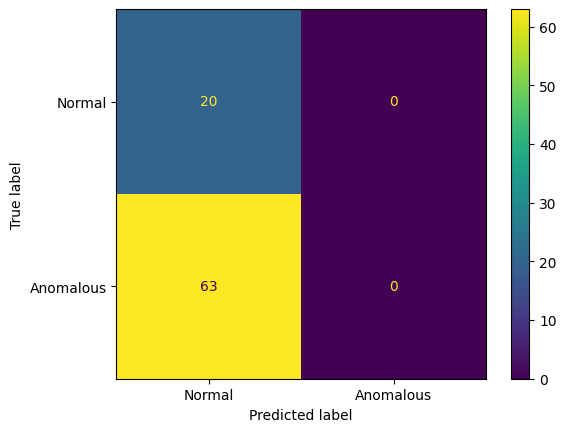

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Convert anomaly scores to binary predictions
threshold = 0.5  # You might need to tune this threshold based on the ROC curve
binary_predictions = [1 if score > threshold else 0 for score in anomaly_scores]

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()


# **Precision, Recall, and F1 Score**

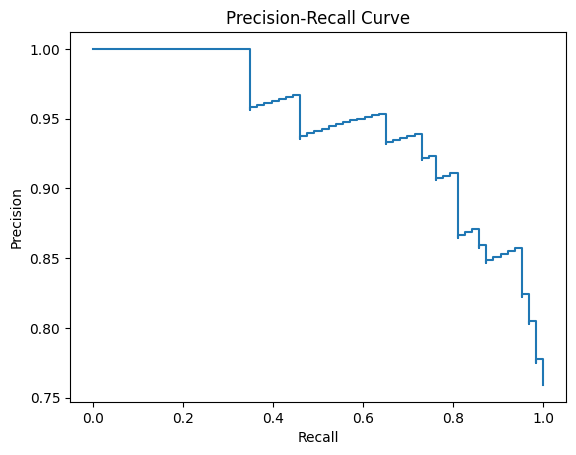

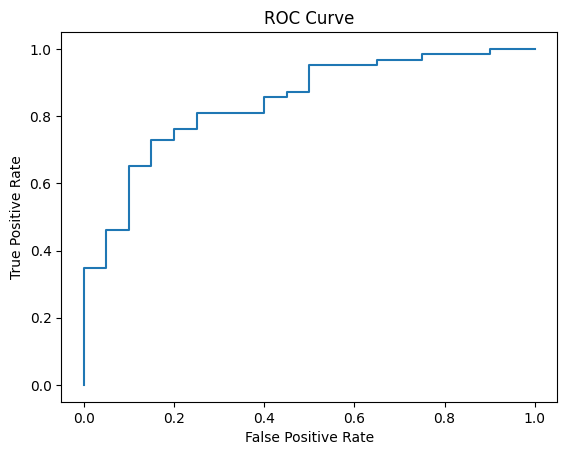

Best threshold based on F1 score: 0.0052870879881083965


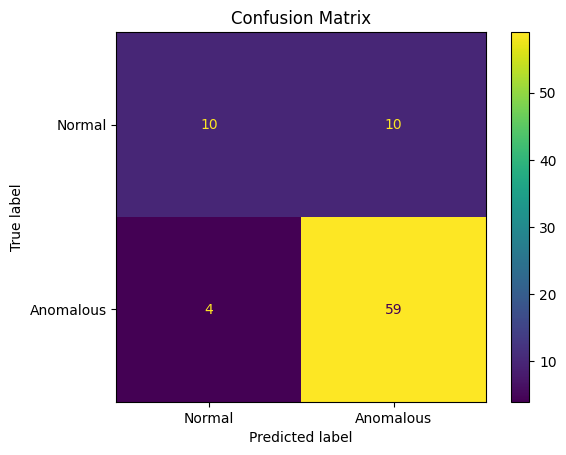

Precision: 0.8551
Recall: 0.9365
F1 Score: 0.8939


In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve, PrecisionRecallDisplay, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(labels, anomaly_scores)
disp_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_pr.plot()
plt.title('Precision-Recall Curve')
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(labels, anomaly_scores)
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
disp_roc.plot()
plt.title('ROC Curve')
plt.show()

# Find the threshold where precision and recall are closest
best_threshold_index = np.argmax(np.abs(precision[:-1] - recall[:-1]))
best_threshold = thresholds_pr[best_threshold_index]

# Alternatively, you can choose the threshold to maximize the F1 score
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_threshold_index]

print(f'Best threshold based on F1 score: {best_threshold}')

# Convert anomaly scores to binary predictions using the selected threshold
binary_predictions = [1 if score > best_threshold else 0 for score in anomaly_scores]

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, binary_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(labels, binary_predictions)
recall = recall_score(labels, binary_predictions)
f1 = f1_score(labels, binary_predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


# **Additional Visualizations**

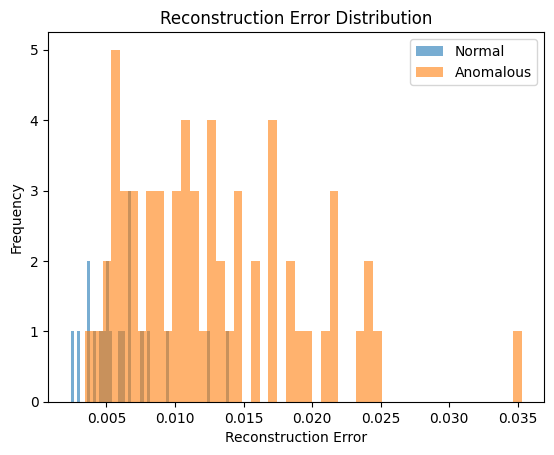

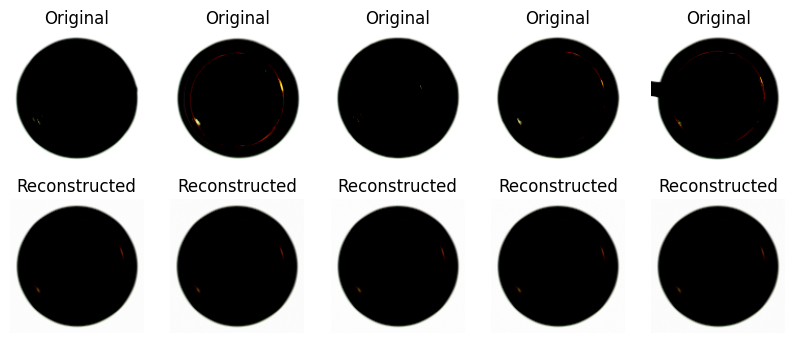

In [13]:
# Reconstruction Error Distribution
normal_errors = [anomaly_scores[i] for i in range(len(anomaly_scores)) if labels[i] == 0]
anomalous_errors = [anomaly_scores[i] for i in range(len(anomaly_scores)) if labels[i] == 1]

plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal')
plt.hist(anomalous_errors, bins=50, alpha=0.6, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

# Sample Reconstructions
def show_reconstructions(model, dataset, num_images=5):
    model.eval()
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        img, label = dataset[i]
        img = img.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            reconstructed = model(img)

        # Display original image
        axes[0, i].imshow(img.squeeze().permute(1, 2, 0).numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display reconstructed image
        axes[1, i].imshow(reconstructed.squeeze().permute(1, 2, 0).numpy())
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()

# Show reconstructions for some samples from the test set
show_reconstructions(model, test_dataset)


For All

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Custom Dataset Class
class MVTecDataset(Dataset):
    def __init__(self, root_dir, object_name, transform=None, train=True):
        self.root_dir = root_dir
        self.object_name = object_name
        self.transform = transform
        self.train = train
        self.image_paths = []
        self.labels = []

        if self.train:
            train_dir = os.path.join(root_dir, object_name, 'train', 'good')
            for img_name in os.listdir(train_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(train_dir, img_name))
                    self.labels.append(0)
        else:
            test_dir = os.path.join(root_dir, object_name, 'test')
            for category in os.listdir(test_dir):
                category_dir = os.path.join(test_dir, category)
                if os.path.isdir(category_dir):
                    label = 0 if category == 'good' else 1
                    for img_name in os.listdir(category_dir):
                        if img_name.endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(os.path.join(category_dir, img_name))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



Processing bottle...
Epoch [1/20], Loss: 0.0987
Epoch [2/20], Loss: 0.0331
Epoch [3/20], Loss: 0.0110
Epoch [4/20], Loss: 0.0124
Epoch [5/20], Loss: 0.0083
Epoch [6/20], Loss: 0.0078
Epoch [7/20], Loss: 0.0069
Epoch [8/20], Loss: 0.0068
Epoch [9/20], Loss: 0.0065
Epoch [10/20], Loss: 0.0051
Epoch [11/20], Loss: 0.0070
Epoch [12/20], Loss: 0.0072
Epoch [13/20], Loss: 0.0058
Epoch [14/20], Loss: 0.0061
Epoch [15/20], Loss: 0.0051
Epoch [16/20], Loss: 0.0061
Epoch [17/20], Loss: 0.0058
Epoch [18/20], Loss: 0.0065
Epoch [19/20], Loss: 0.0050
Epoch [20/20], Loss: 0.0073
Best threshold for bottle based on F1 score: 0.005298498552292585


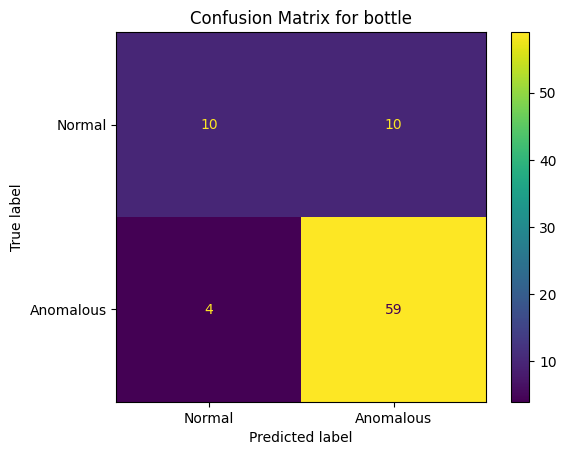

Precision for bottle: 0.8551
Recall for bottle: 0.9365
F1 Score for bottle: 0.8939


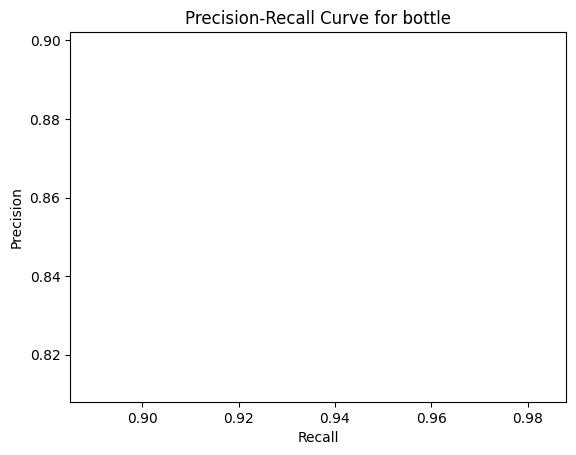

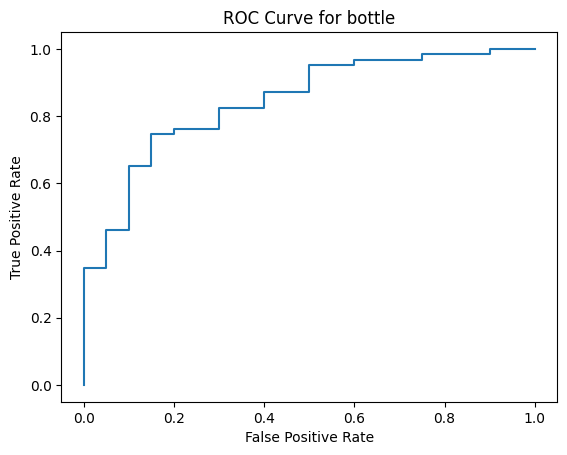

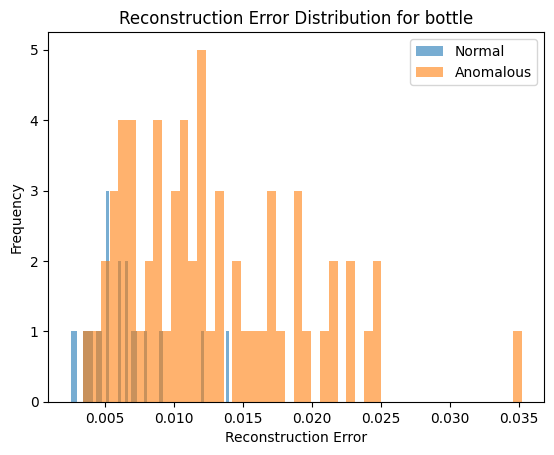

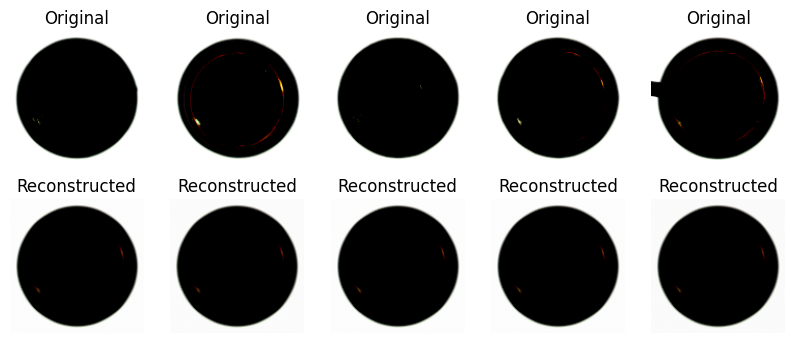

Processing cable...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0874
Epoch [2/20], Loss: 0.0597
Epoch [3/20], Loss: 0.0613
Epoch [4/20], Loss: 0.0561
Epoch [5/20], Loss: 0.0556
Epoch [6/20], Loss: 0.0561
Epoch [7/20], Loss: 0.0577
Epoch [8/20], Loss: 0.0573
Epoch [9/20], Loss: 0.0579
Epoch [10/20], Loss: 0.0542
Epoch [11/20], Loss: 0.0545
Epoch [12/20], Loss: 0.0543
Epoch [13/20], Loss: 0.0561
Epoch [14/20], Loss: 0.0494
Epoch [15/20], Loss: 0.0546
Epoch [16/20], Loss: 0.0512
Epoch [17/20], Loss: 0.0519
Epoch [18/20], Loss: 0.0504
Epoch [19/20], Loss: 0.0496
Epoch [20/20], Loss: 0.0500
Best threshold for cable based on F1 score: 0.03887612000107765


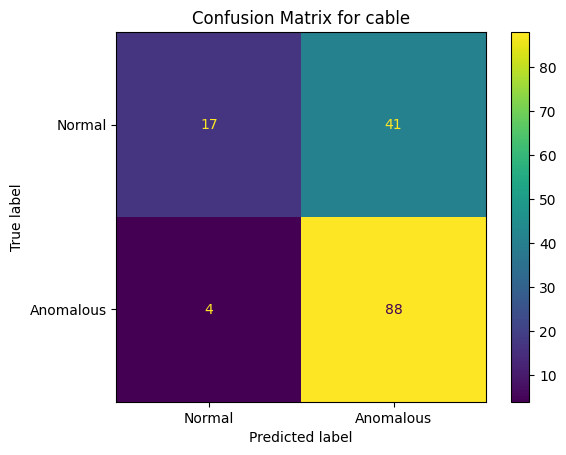

Precision for cable: 0.6822
Recall for cable: 0.9565
F1 Score for cable: 0.7964


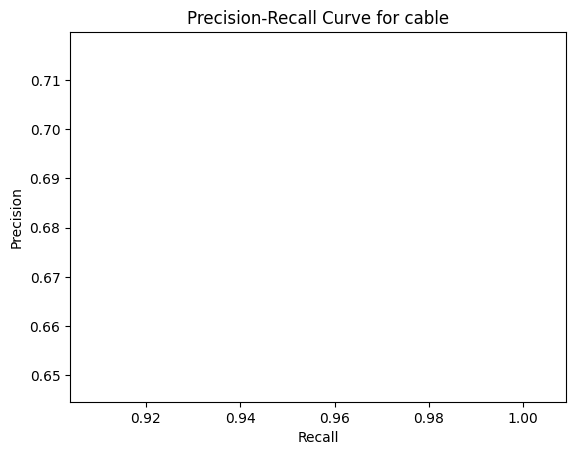

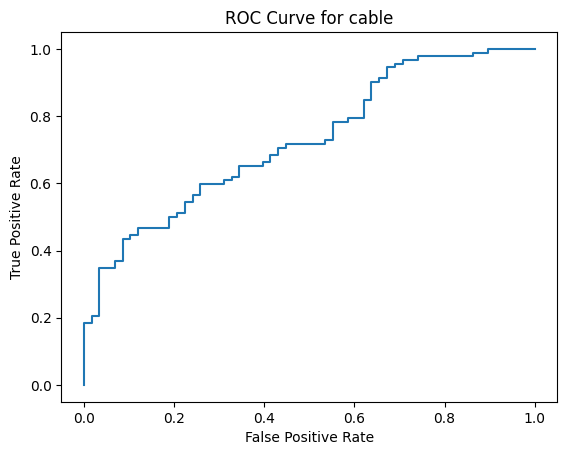

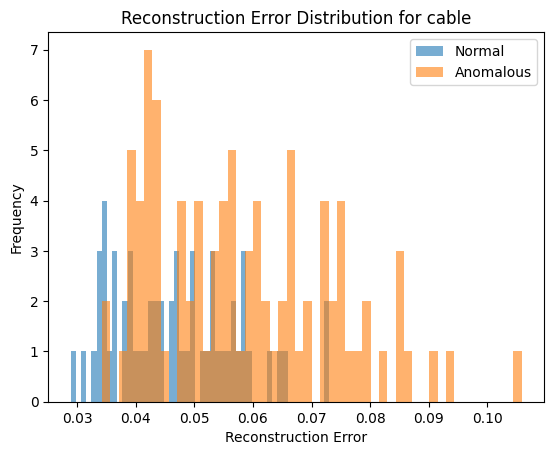

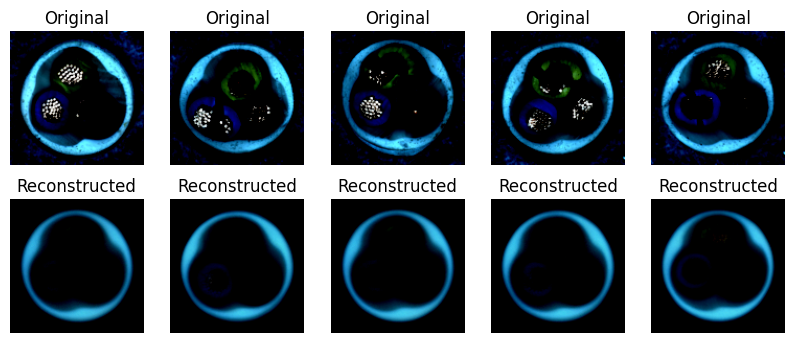

Processing capsule...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0691
Epoch [2/20], Loss: 0.0131
Epoch [3/20], Loss: 0.0059
Epoch [4/20], Loss: 0.0026
Epoch [5/20], Loss: 0.0026
Epoch [6/20], Loss: 0.0018
Epoch [7/20], Loss: 0.0014
Epoch [8/20], Loss: 0.0015
Epoch [9/20], Loss: 0.0013
Epoch [10/20], Loss: 0.0018
Epoch [11/20], Loss: 0.0015
Epoch [12/20], Loss: 0.0021
Epoch [13/20], Loss: 0.0013
Epoch [14/20], Loss: 0.0016
Epoch [15/20], Loss: 0.0016
Epoch [16/20], Loss: 0.0014
Epoch [17/20], Loss: 0.0021
Epoch [18/20], Loss: 0.0024
Epoch [19/20], Loss: 0.0021
Epoch [20/20], Loss: 0.0014
Best threshold for capsule based on F1 score: 0.0004402437771204859


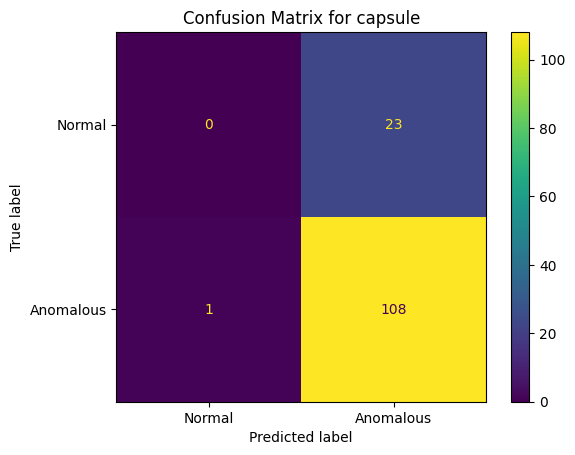

Precision for capsule: 0.8244
Recall for capsule: 0.9908
F1 Score for capsule: 0.9000


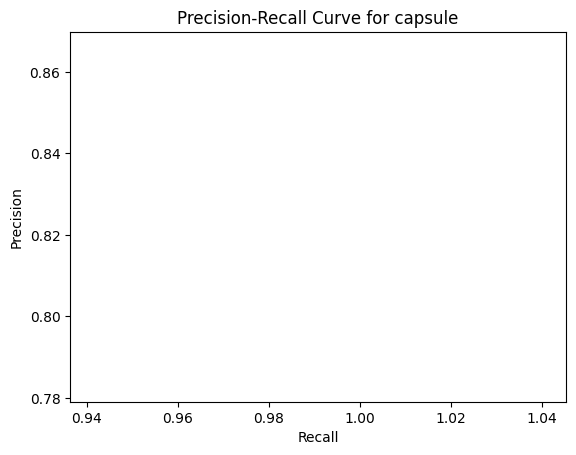

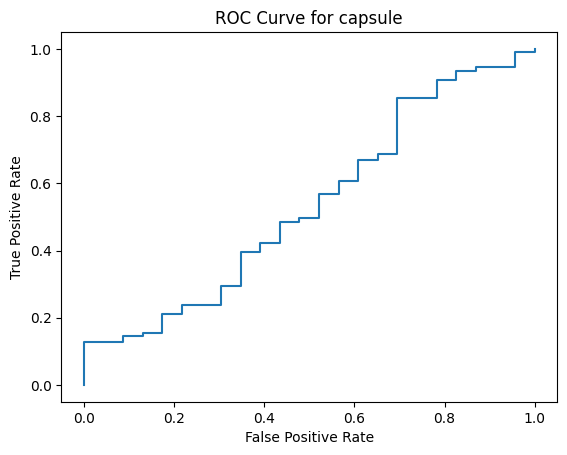

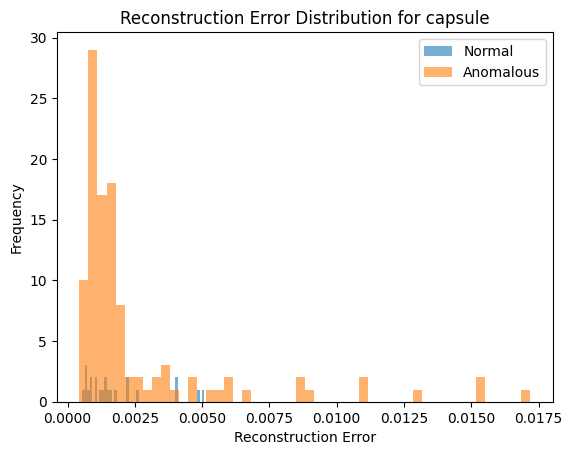

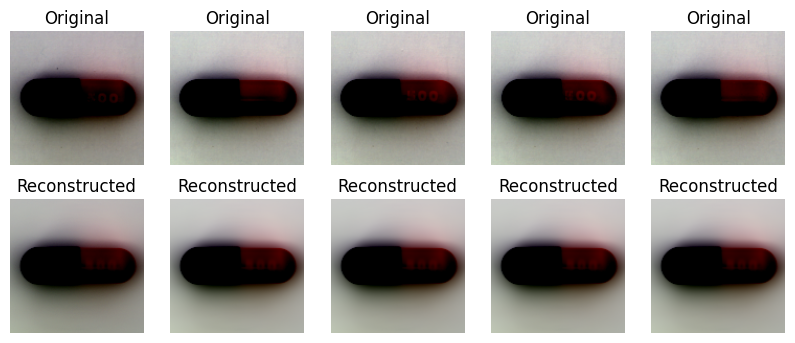

Processing carpet...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0305
Epoch [2/20], Loss: 0.0283
Epoch [3/20], Loss: 0.0265
Epoch [4/20], Loss: 0.0273
Epoch [5/20], Loss: 0.0265
Epoch [6/20], Loss: 0.0274
Epoch [7/20], Loss: 0.0264
Epoch [8/20], Loss: 0.0274
Epoch [9/20], Loss: 0.0274
Epoch [10/20], Loss: 0.0267
Epoch [11/20], Loss: 0.0267
Epoch [12/20], Loss: 0.0262
Epoch [13/20], Loss: 0.0259
Epoch [14/20], Loss: 0.0261
Epoch [15/20], Loss: 0.0274
Epoch [16/20], Loss: 0.0266
Epoch [17/20], Loss: 0.0262
Epoch [18/20], Loss: 0.0262
Epoch [19/20], Loss: 0.0262
Epoch [20/20], Loss: 0.0261
Best threshold for carpet based on F1 score: 0.022234728559851646


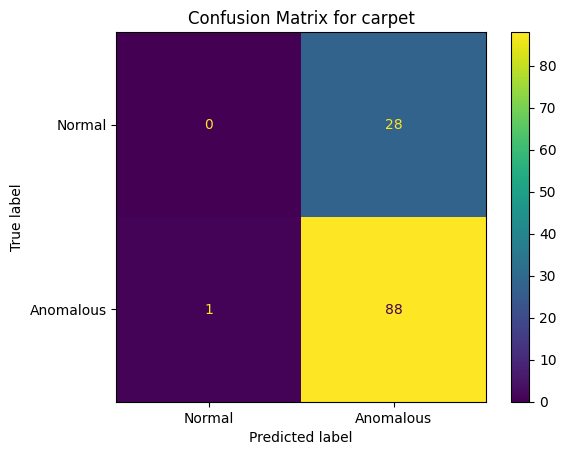

Precision for carpet: 0.7586
Recall for carpet: 0.9888
F1 Score for carpet: 0.8585


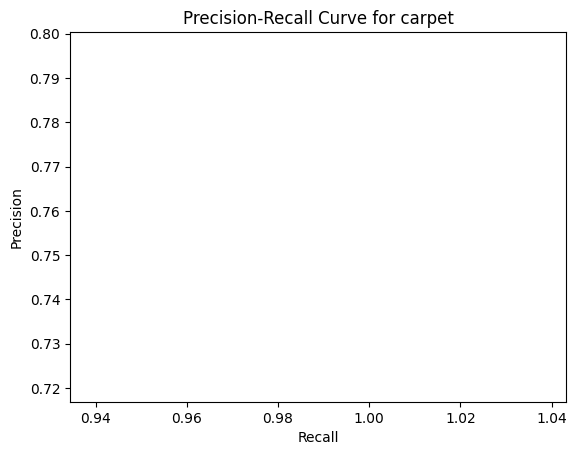

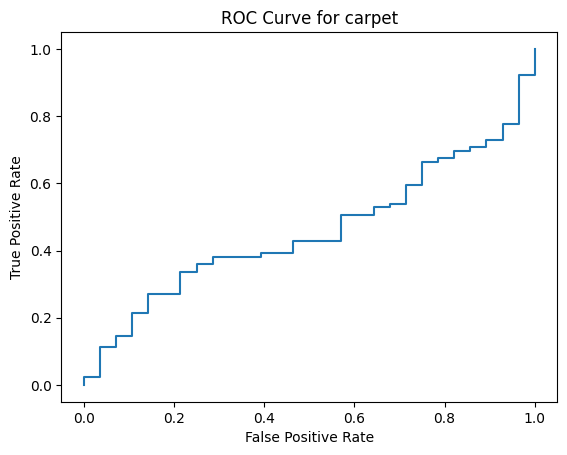

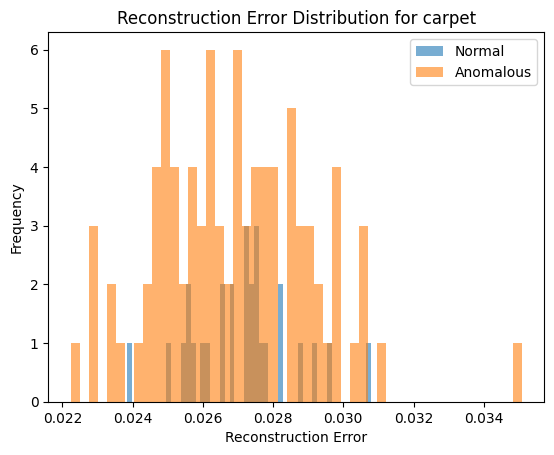

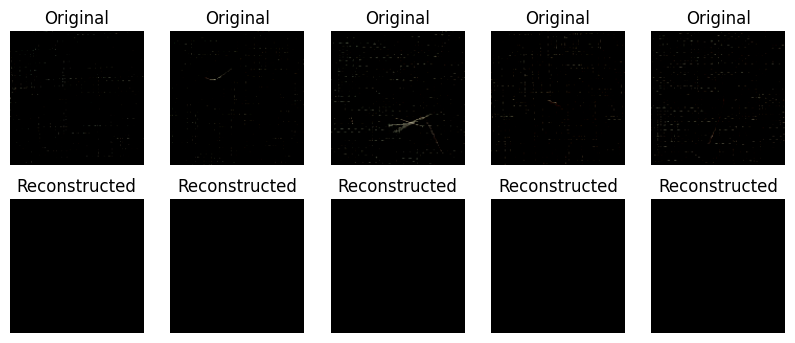

Processing grid...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0848
Epoch [2/20], Loss: 0.0935
Epoch [3/20], Loss: 0.0790
Epoch [4/20], Loss: 0.0860
Epoch [5/20], Loss: 0.0826
Epoch [6/20], Loss: 0.0857
Epoch [7/20], Loss: 0.0793
Epoch [8/20], Loss: 0.0634
Epoch [9/20], Loss: 0.0889
Epoch [10/20], Loss: 0.0622
Epoch [11/20], Loss: 0.0858
Epoch [12/20], Loss: 0.0937
Epoch [13/20], Loss: 0.0838
Epoch [14/20], Loss: 0.0800
Epoch [15/20], Loss: 0.1185
Epoch [16/20], Loss: 0.0803
Epoch [17/20], Loss: 0.0717
Epoch [18/20], Loss: 0.0789
Epoch [19/20], Loss: 0.0800
Epoch [20/20], Loss: 0.0639
Best threshold for grid based on F1 score: 0.03962365537881851


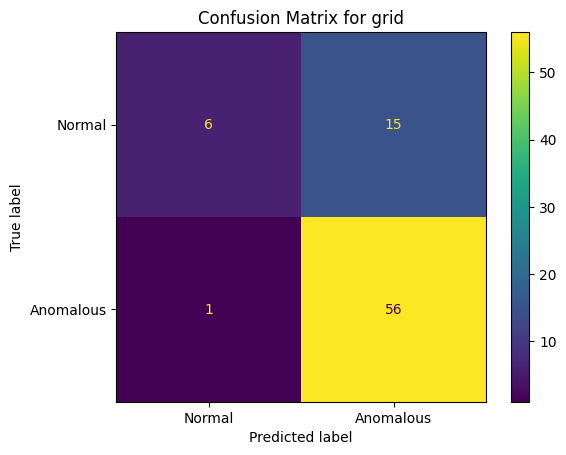

Precision for grid: 0.7887
Recall for grid: 0.9825
F1 Score for grid: 0.8750


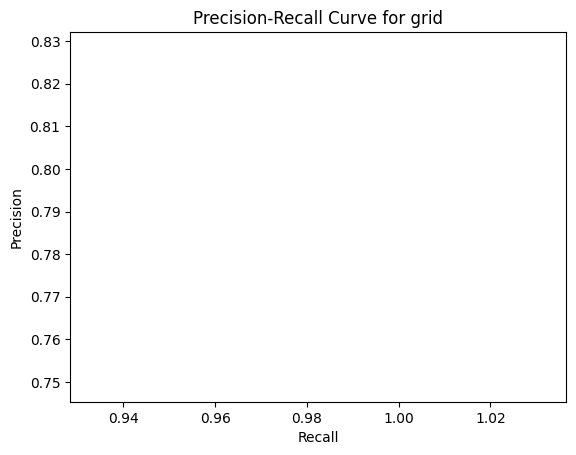

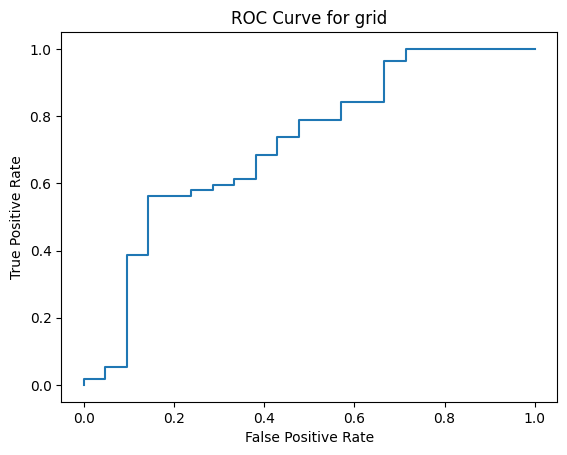

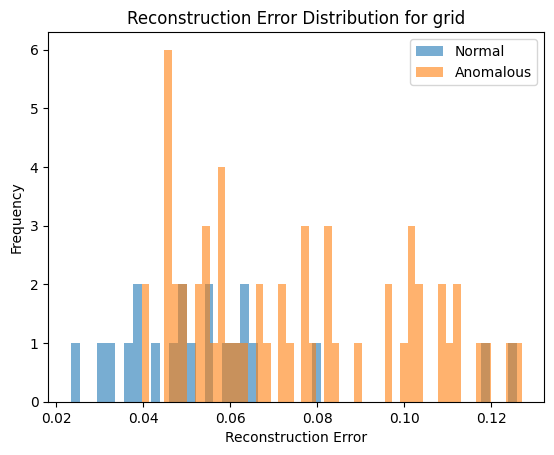

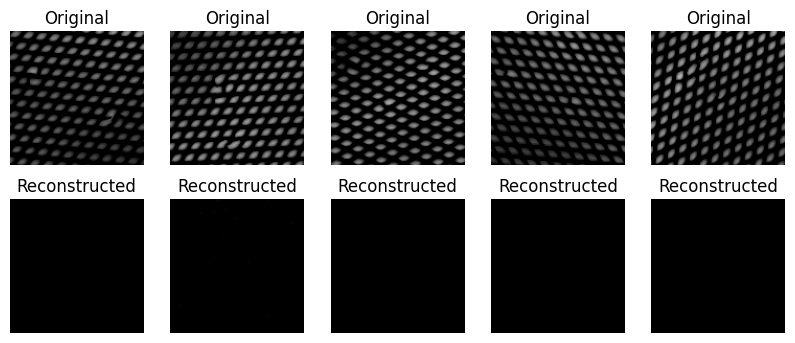

Processing hazelnut...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0285
Epoch [2/20], Loss: 0.0235
Epoch [3/20], Loss: 0.0105
Epoch [4/20], Loss: 0.0093
Epoch [5/20], Loss: 0.0101
Epoch [6/20], Loss: 0.0059
Epoch [7/20], Loss: 0.0138
Epoch [8/20], Loss: 0.0053
Epoch [9/20], Loss: 0.0114
Epoch [10/20], Loss: 0.0077
Epoch [11/20], Loss: 0.0102
Epoch [12/20], Loss: 0.0078
Epoch [13/20], Loss: 0.0139
Epoch [14/20], Loss: 0.0087
Epoch [15/20], Loss: 0.0094
Epoch [16/20], Loss: 0.0062
Epoch [17/20], Loss: 0.0086
Epoch [18/20], Loss: 0.0056
Epoch [19/20], Loss: 0.0103
Epoch [20/20], Loss: 0.0065
Best threshold for hazelnut based on F1 score: 0.004316580016165972


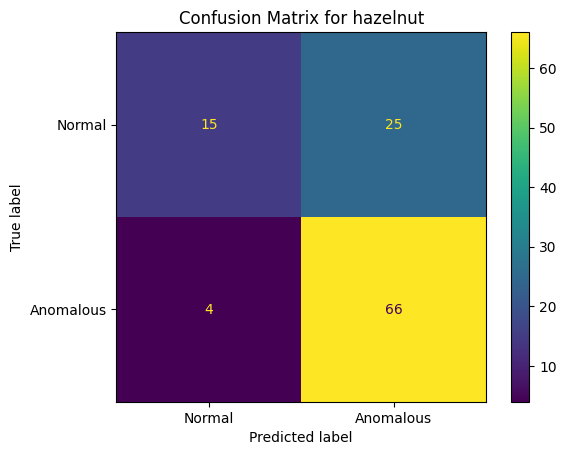

Precision for hazelnut: 0.7253
Recall for hazelnut: 0.9429
F1 Score for hazelnut: 0.8199


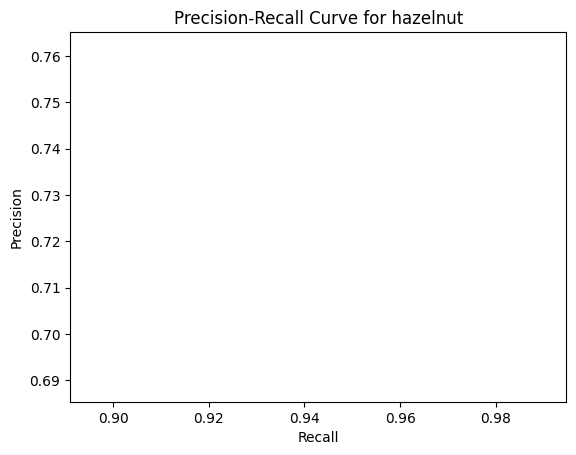

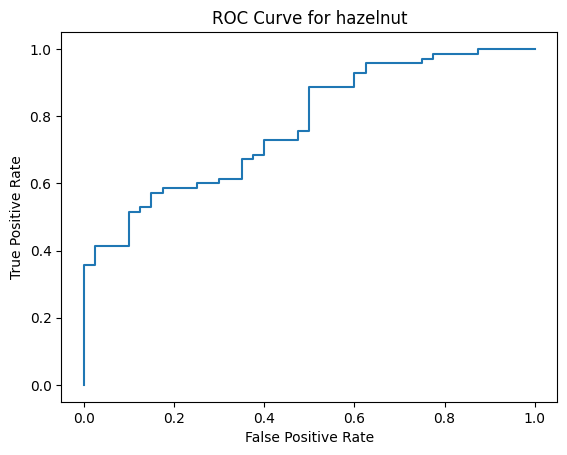

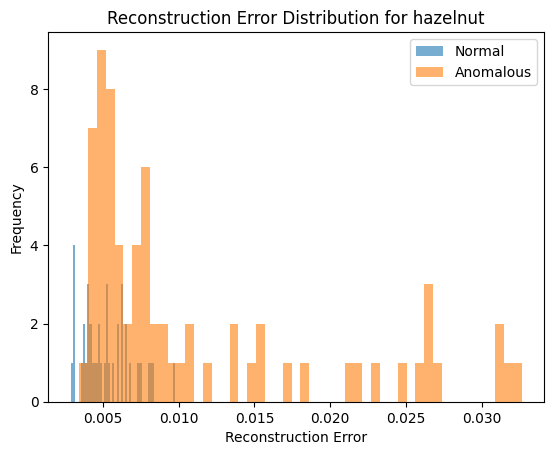

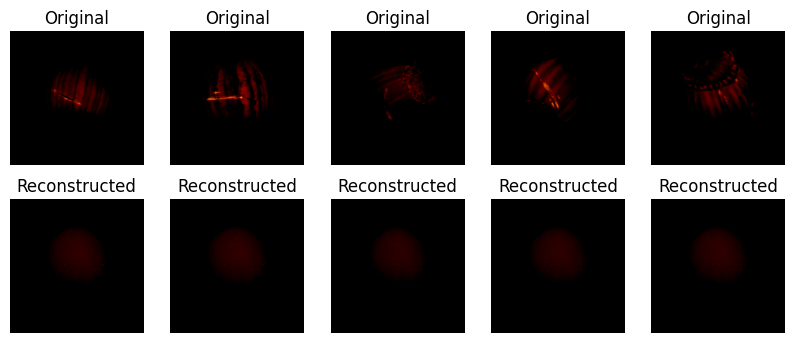

Processing leather...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0405
Epoch [2/20], Loss: 0.0064
Epoch [3/20], Loss: 0.0024
Epoch [4/20], Loss: 0.0019
Epoch [5/20], Loss: 0.0015
Epoch [6/20], Loss: 0.0015
Epoch [7/20], Loss: 0.0015
Epoch [8/20], Loss: 0.0016
Epoch [9/20], Loss: 0.0021
Epoch [10/20], Loss: 0.0012
Epoch [11/20], Loss: 0.0012
Epoch [12/20], Loss: 0.0010
Epoch [13/20], Loss: 0.0012
Epoch [14/20], Loss: 0.0011
Epoch [15/20], Loss: 0.0011
Epoch [16/20], Loss: 0.0010
Epoch [17/20], Loss: 0.0010
Epoch [18/20], Loss: 0.0011
Epoch [19/20], Loss: 0.0011
Epoch [20/20], Loss: 0.0011
Best threshold for leather based on F1 score: 0.0015918154967948794


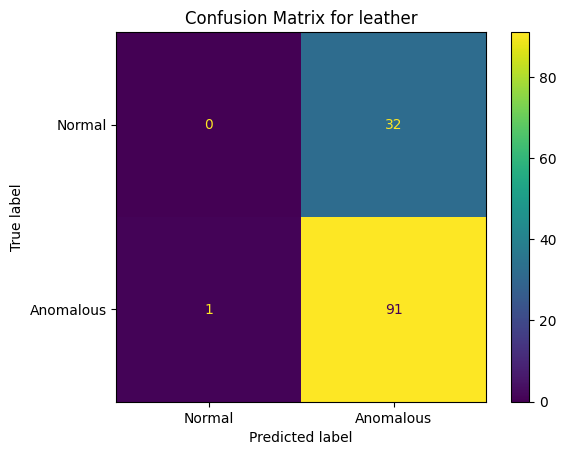

Precision for leather: 0.7398
Recall for leather: 0.9891
F1 Score for leather: 0.8465


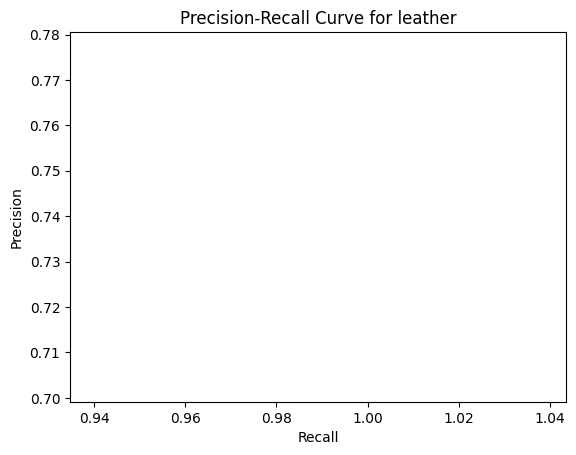

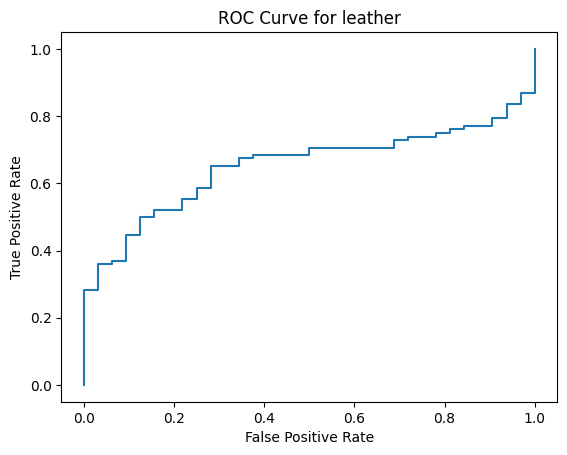

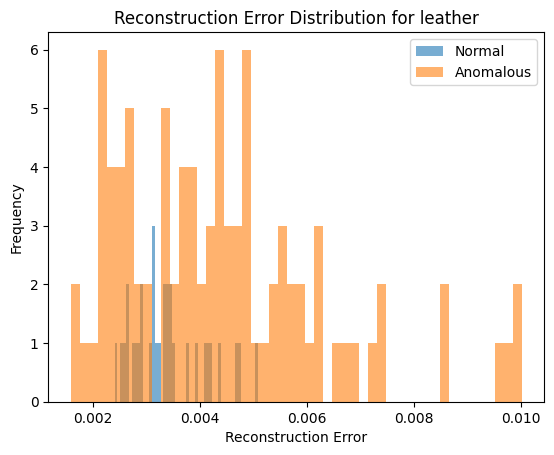

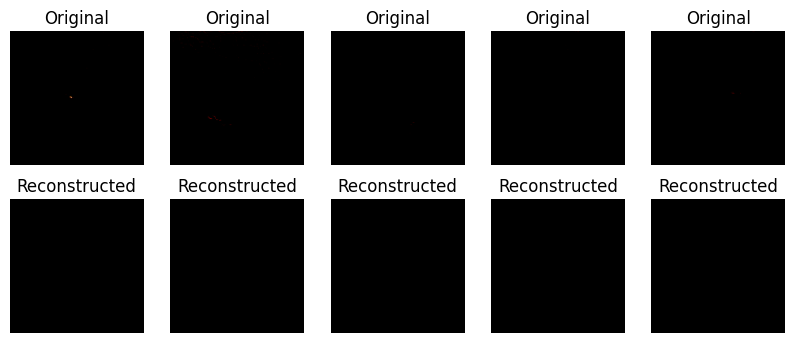

Processing metal_nut...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.1206
Epoch [2/20], Loss: 0.0492
Epoch [3/20], Loss: 0.0411
Epoch [4/20], Loss: 0.0398
Epoch [5/20], Loss: 0.0399
Epoch [6/20], Loss: 0.0427
Epoch [7/20], Loss: 0.0397
Epoch [8/20], Loss: 0.0433
Epoch [9/20], Loss: 0.0400
Epoch [10/20], Loss: 0.0388
Epoch [11/20], Loss: 0.0379
Epoch [12/20], Loss: 0.0374
Epoch [13/20], Loss: 0.0329
Epoch [14/20], Loss: 0.0298
Epoch [15/20], Loss: 0.0279
Epoch [16/20], Loss: 0.0251
Epoch [17/20], Loss: 0.0247
Epoch [18/20], Loss: 0.0221
Epoch [19/20], Loss: 0.0198
Epoch [20/20], Loss: 0.0207
Best threshold for metal_nut based on F1 score: 0.011396276764571667


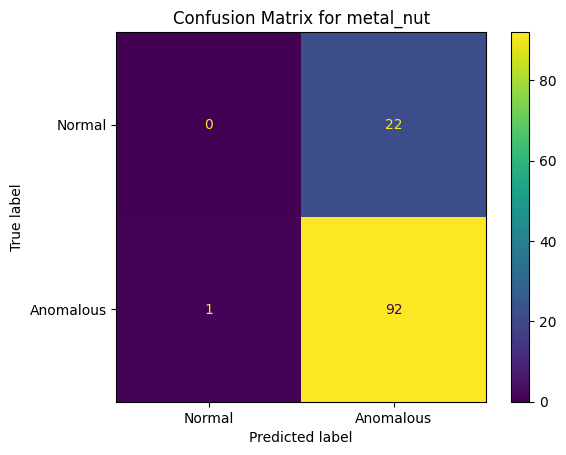

Precision for metal_nut: 0.8070
Recall for metal_nut: 0.9892
F1 Score for metal_nut: 0.8889


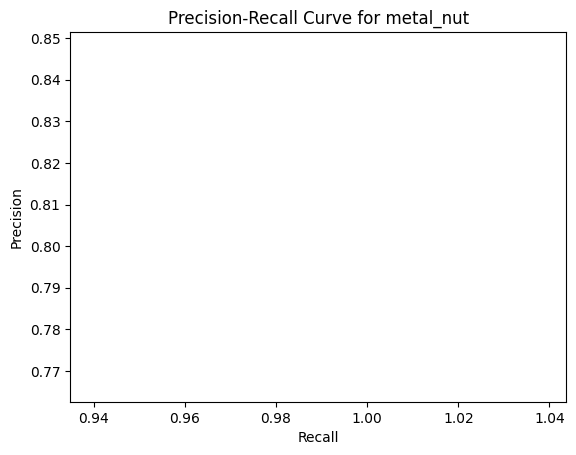

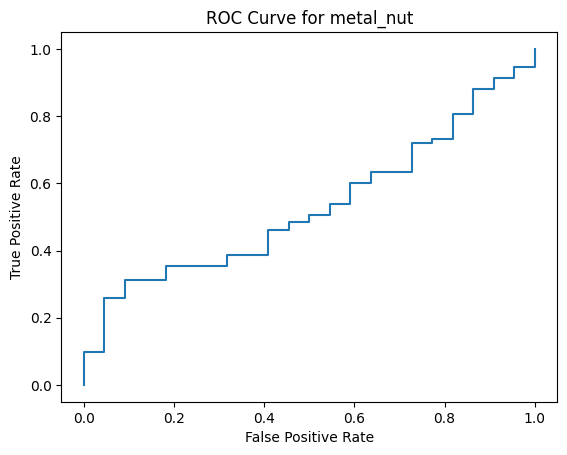

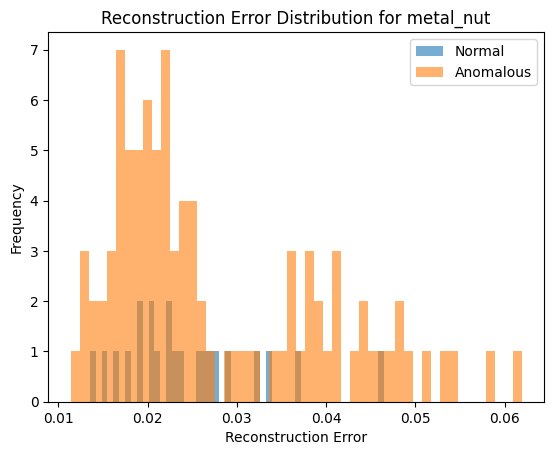

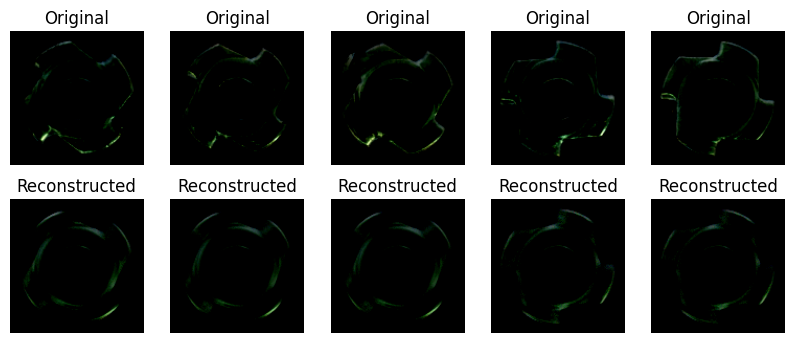

Processing pill...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0982
Epoch [2/20], Loss: 0.0214
Epoch [3/20], Loss: 0.0044
Epoch [4/20], Loss: 0.0031
Epoch [5/20], Loss: 0.0021
Epoch [6/20], Loss: 0.0023
Epoch [7/20], Loss: 0.0017
Epoch [8/20], Loss: 0.0017
Epoch [9/20], Loss: 0.0022
Epoch [10/20], Loss: 0.0018
Epoch [11/20], Loss: 0.0021
Epoch [12/20], Loss: 0.0020
Epoch [13/20], Loss: 0.0018
Epoch [14/20], Loss: 0.0019
Epoch [15/20], Loss: 0.0017
Epoch [16/20], Loss: 0.0019
Epoch [17/20], Loss: 0.0018
Epoch [18/20], Loss: 0.0022
Epoch [19/20], Loss: 0.0022
Epoch [20/20], Loss: 0.0017
Best threshold for pill based on F1 score: 0.0010040163761004806


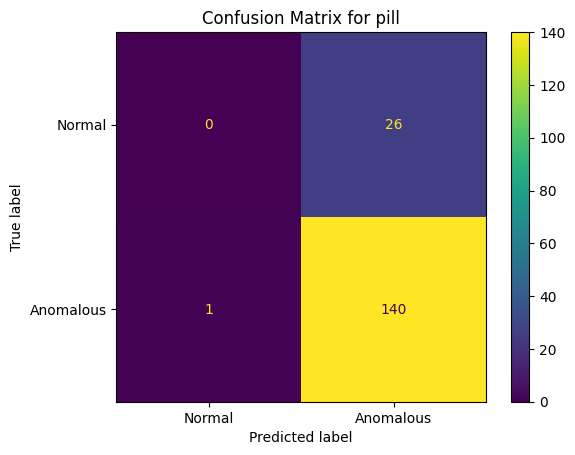

Precision for pill: 0.8434
Recall for pill: 0.9929
F1 Score for pill: 0.9121


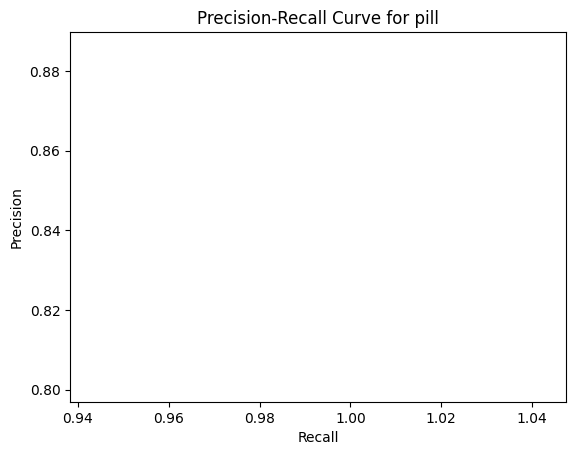

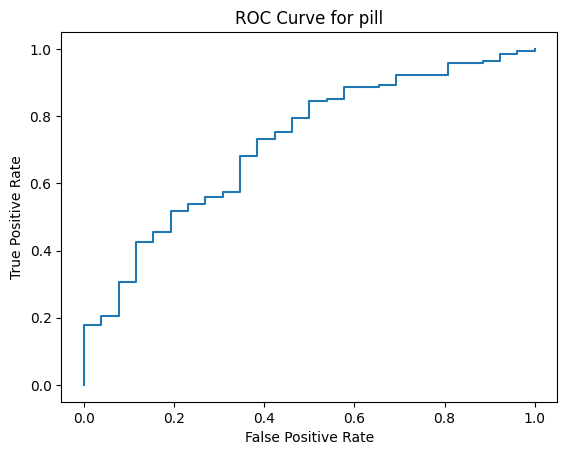

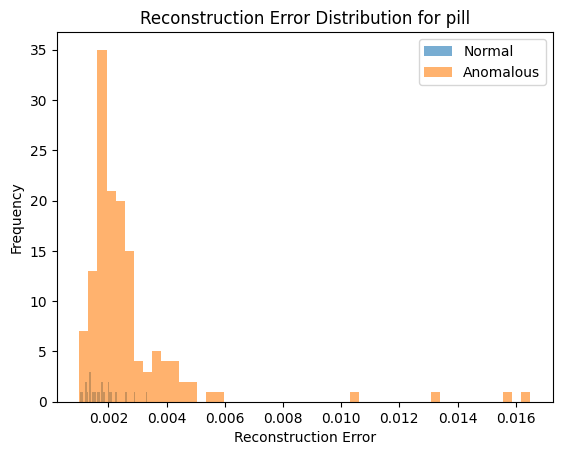

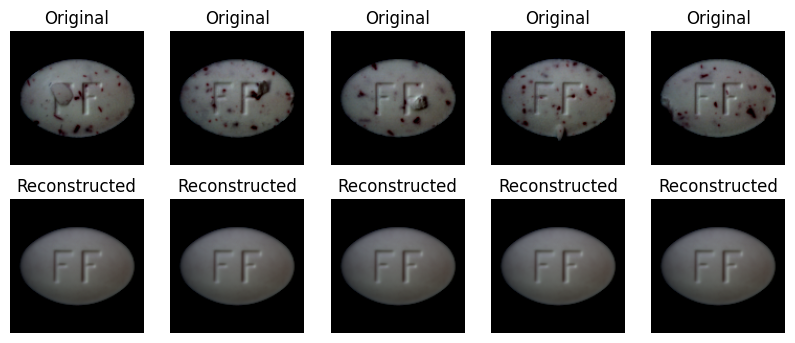

Processing screw...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0644
Epoch [2/20], Loss: 0.0485
Epoch [3/20], Loss: 0.0466
Epoch [4/20], Loss: 0.0443
Epoch [5/20], Loss: 0.0385
Epoch [6/20], Loss: 0.0337
Epoch [7/20], Loss: 0.0344
Epoch [8/20], Loss: 0.0289
Epoch [9/20], Loss: 0.0231
Epoch [10/20], Loss: 0.0246
Epoch [11/20], Loss: 0.0223
Epoch [12/20], Loss: 0.0214
Epoch [13/20], Loss: 0.0202
Epoch [14/20], Loss: 0.0188
Epoch [15/20], Loss: 0.0191
Epoch [16/20], Loss: 0.0201
Epoch [17/20], Loss: 0.0190
Epoch [18/20], Loss: 0.0192
Epoch [19/20], Loss: 0.0199
Epoch [20/20], Loss: 0.0219
Best threshold for screw based on F1 score: 0.008806348778307438


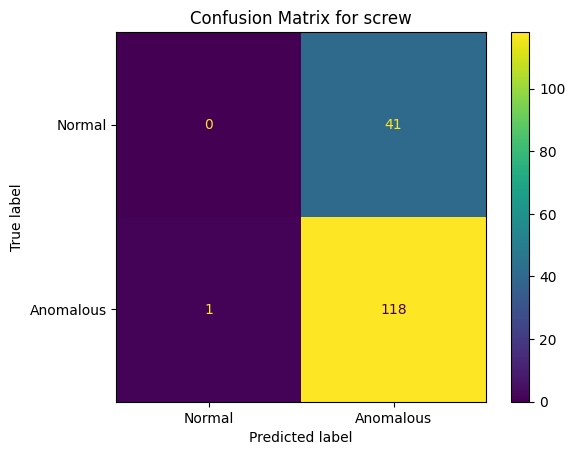

Precision for screw: 0.7421
Recall for screw: 0.9916
F1 Score for screw: 0.8489


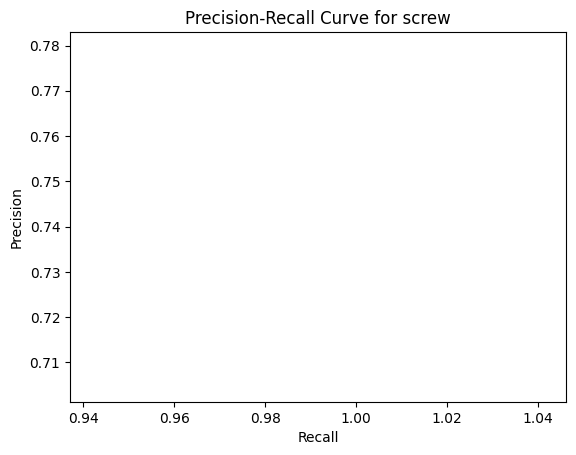

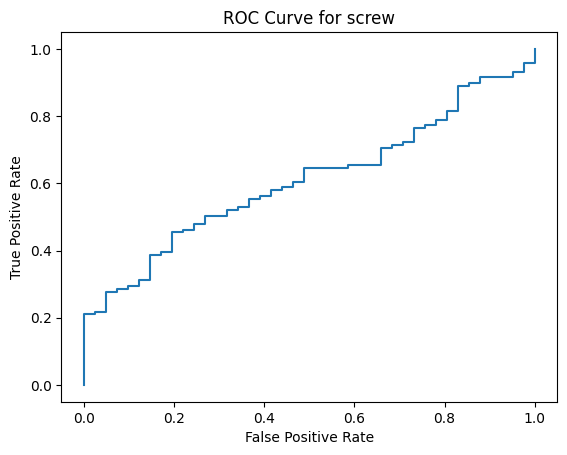

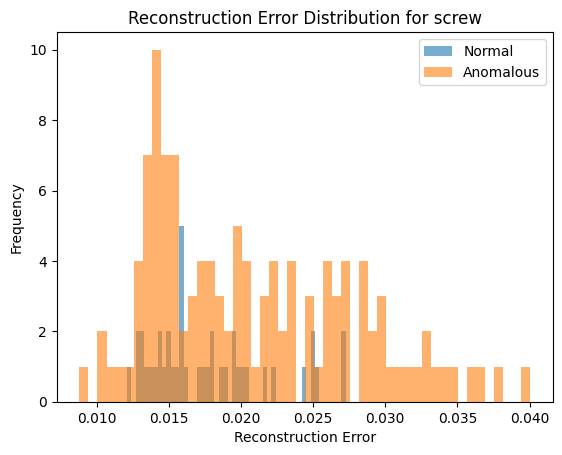

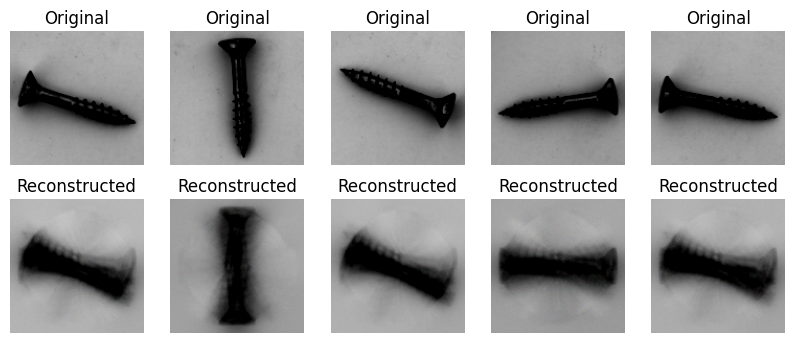

Processing tile...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0577
Epoch [2/20], Loss: 0.0494
Epoch [3/20], Loss: 0.0498
Epoch [4/20], Loss: 0.0448
Epoch [5/20], Loss: 0.0483
Epoch [6/20], Loss: 0.0624
Epoch [7/20], Loss: 0.0500
Epoch [8/20], Loss: 0.0483
Epoch [9/20], Loss: 0.0538
Epoch [10/20], Loss: 0.0468
Epoch [11/20], Loss: 0.0443
Epoch [12/20], Loss: 0.0531
Epoch [13/20], Loss: 0.0454
Epoch [14/20], Loss: 0.0482
Epoch [15/20], Loss: 0.0545
Epoch [16/20], Loss: 0.0506
Epoch [17/20], Loss: 0.0478
Epoch [18/20], Loss: 0.0500
Epoch [19/20], Loss: 0.0489
Epoch [20/20], Loss: 0.0460
Best threshold for tile based on F1 score: 0.037950947880744934


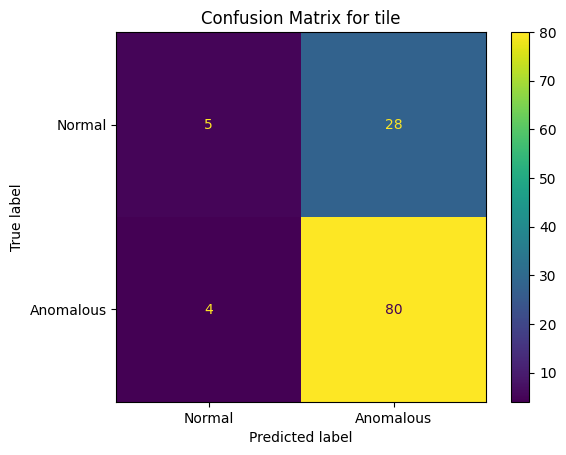

Precision for tile: 0.7407
Recall for tile: 0.9524
F1 Score for tile: 0.8333


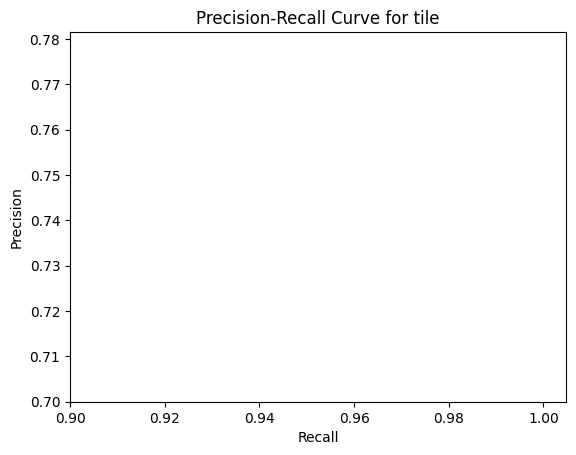

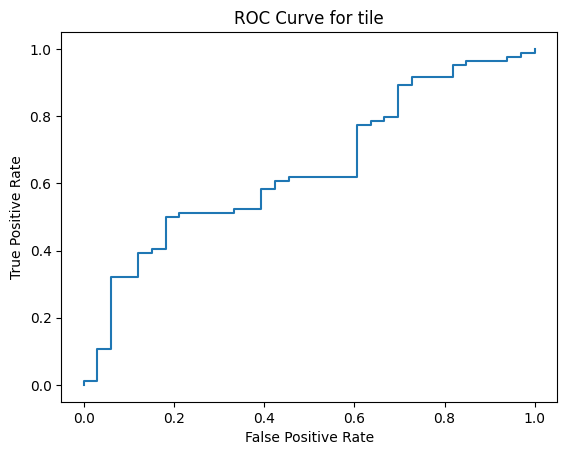

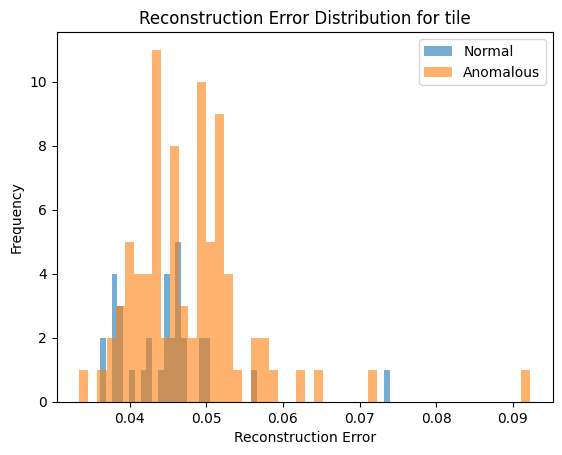

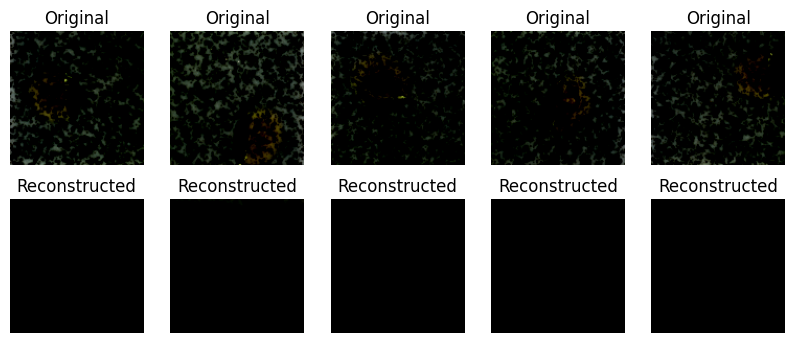

Processing toothbrush...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.5385
Epoch [2/20], Loss: 0.4863
Epoch [3/20], Loss: 0.3149
Epoch [4/20], Loss: 0.0701
Epoch [5/20], Loss: 0.0750
Epoch [6/20], Loss: 0.0497
Epoch [7/20], Loss: 0.0303
Epoch [8/20], Loss: 0.0265
Epoch [9/20], Loss: 0.0203
Epoch [10/20], Loss: 0.0173
Epoch [11/20], Loss: 0.0170
Epoch [12/20], Loss: 0.0155
Epoch [13/20], Loss: 0.0132
Epoch [14/20], Loss: 0.0106
Epoch [15/20], Loss: 0.0101
Epoch [16/20], Loss: 0.0095
Epoch [17/20], Loss: 0.0091
Epoch [18/20], Loss: 0.0089
Epoch [19/20], Loss: 0.0083
Epoch [20/20], Loss: 0.0084
Best threshold for toothbrush based on F1 score: 0.011495429091155529


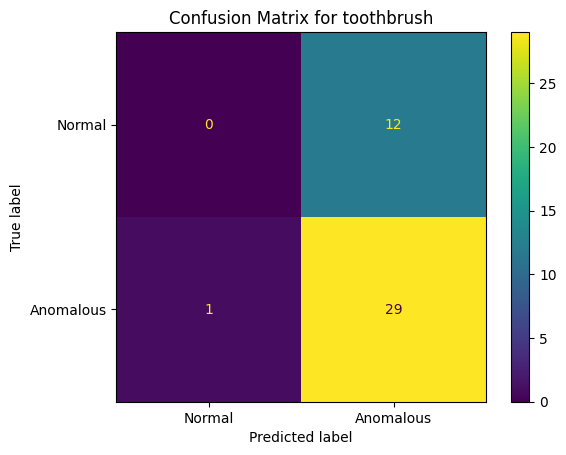

Precision for toothbrush: 0.7073
Recall for toothbrush: 0.9667
F1 Score for toothbrush: 0.8169


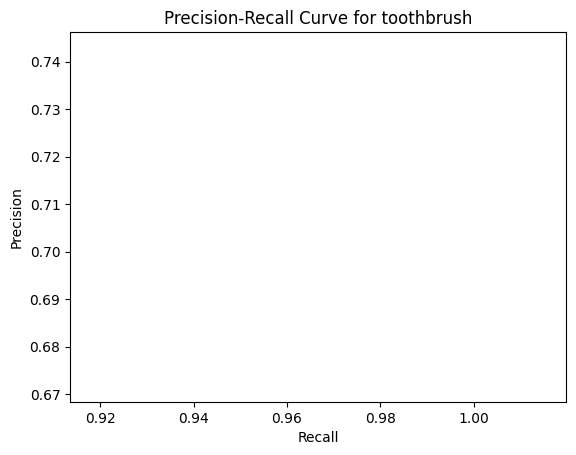

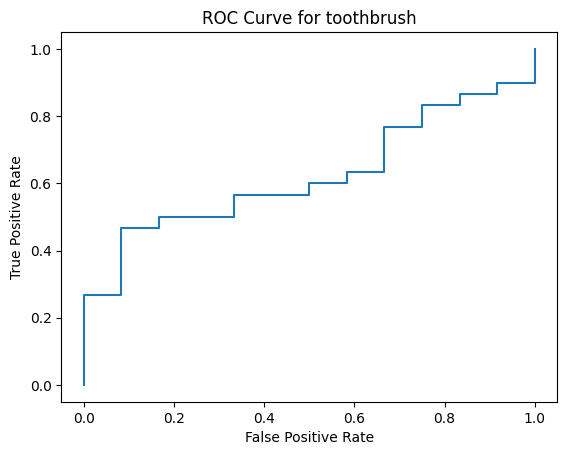

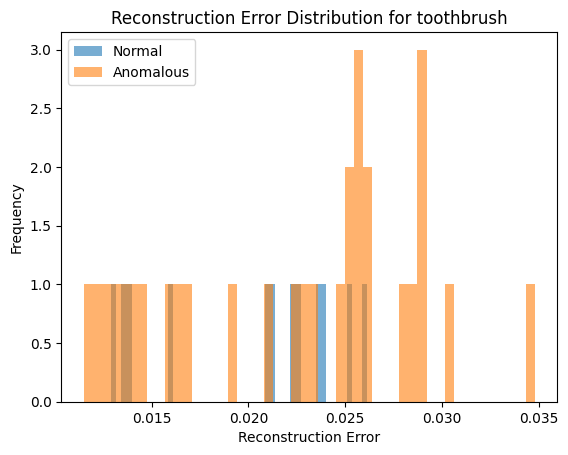

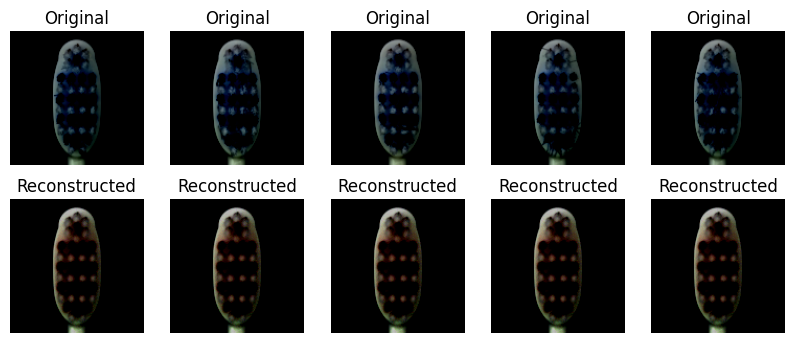

Processing transistor...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0867
Epoch [2/20], Loss: 0.0430
Epoch [3/20], Loss: 0.0314
Epoch [4/20], Loss: 0.0280
Epoch [5/20], Loss: 0.0278
Epoch [6/20], Loss: 0.0271
Epoch [7/20], Loss: 0.0248
Epoch [8/20], Loss: 0.0246
Epoch [9/20], Loss: 0.0241
Epoch [10/20], Loss: 0.0257
Epoch [11/20], Loss: 0.0266
Epoch [12/20], Loss: 0.0282
Epoch [13/20], Loss: 0.0236
Epoch [14/20], Loss: 0.0284
Epoch [15/20], Loss: 0.0274
Epoch [16/20], Loss: 0.0255
Epoch [17/20], Loss: 0.0251
Epoch [18/20], Loss: 0.0238
Epoch [19/20], Loss: 0.0209
Epoch [20/20], Loss: 0.0186
Best threshold for transistor based on F1 score: 0.02297605574131012


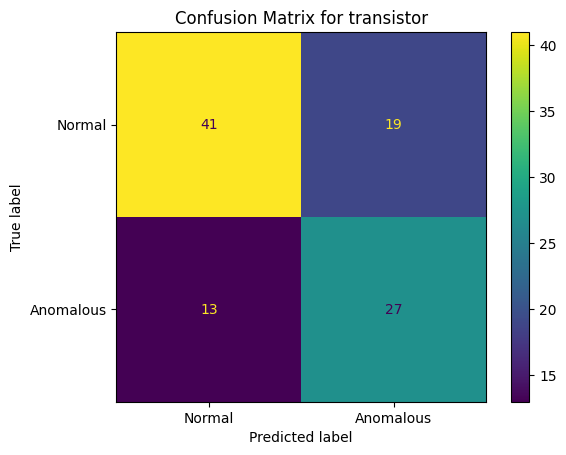

Precision for transistor: 0.5870
Recall for transistor: 0.6750
F1 Score for transistor: 0.6279


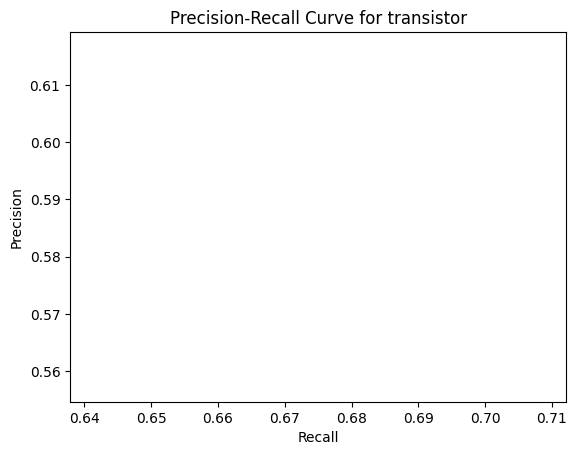

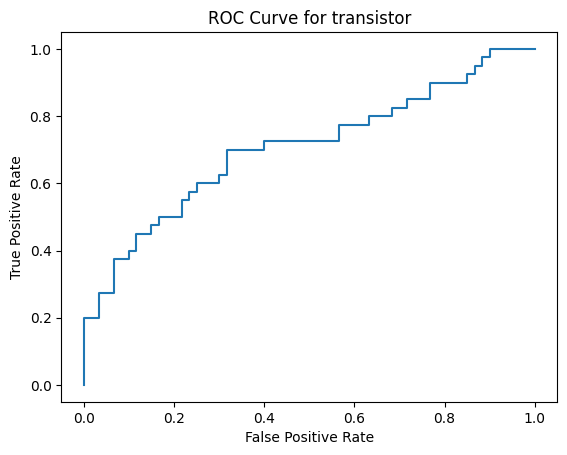

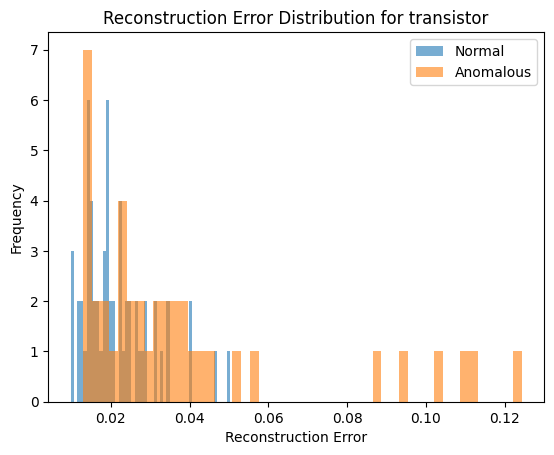

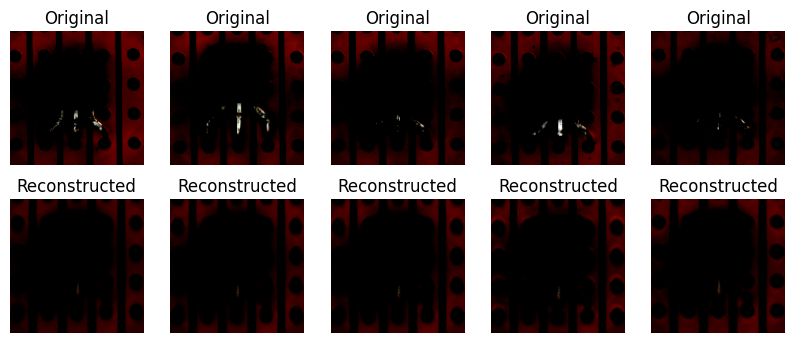

Processing wood...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0206
Epoch [2/20], Loss: 0.0157
Epoch [3/20], Loss: 0.0121
Epoch [4/20], Loss: 0.0130
Epoch [5/20], Loss: 0.0118
Epoch [6/20], Loss: 0.0118
Epoch [7/20], Loss: 0.0093
Epoch [8/20], Loss: 0.0095
Epoch [9/20], Loss: 0.0101
Epoch [10/20], Loss: 0.0080
Epoch [11/20], Loss: 0.0091
Epoch [12/20], Loss: 0.0099
Epoch [13/20], Loss: 0.0108
Epoch [14/20], Loss: 0.0111
Epoch [15/20], Loss: 0.0082
Epoch [16/20], Loss: 0.0094
Epoch [17/20], Loss: 0.0089
Epoch [18/20], Loss: 0.0075
Epoch [19/20], Loss: 0.0081
Epoch [20/20], Loss: 0.0072
Best threshold for wood based on F1 score: 0.007588501553982496


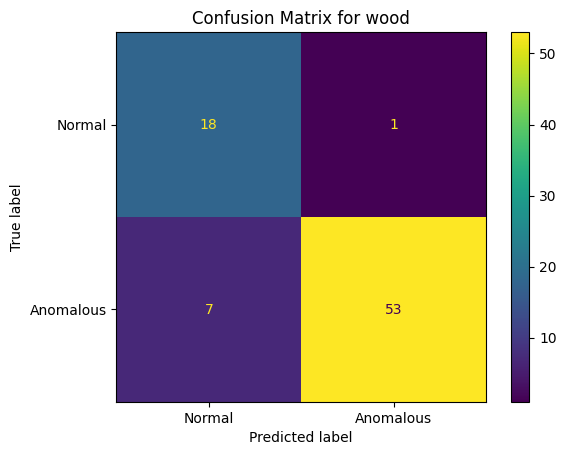

Precision for wood: 0.9815
Recall for wood: 0.8833
F1 Score for wood: 0.9298


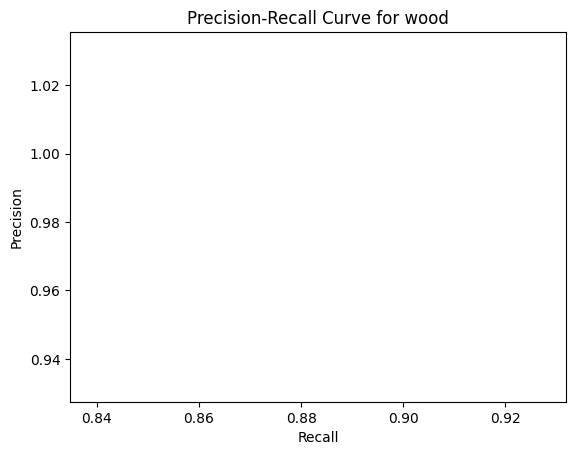

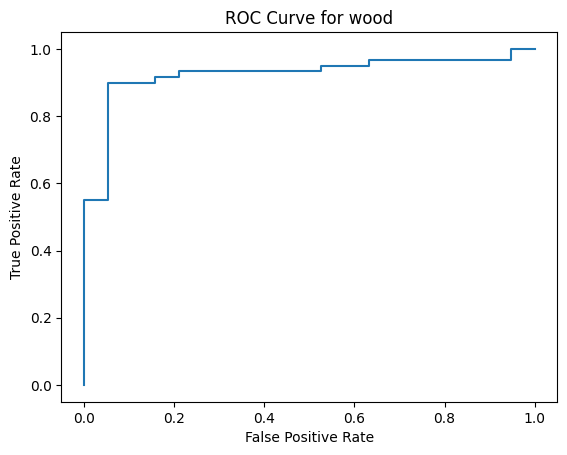

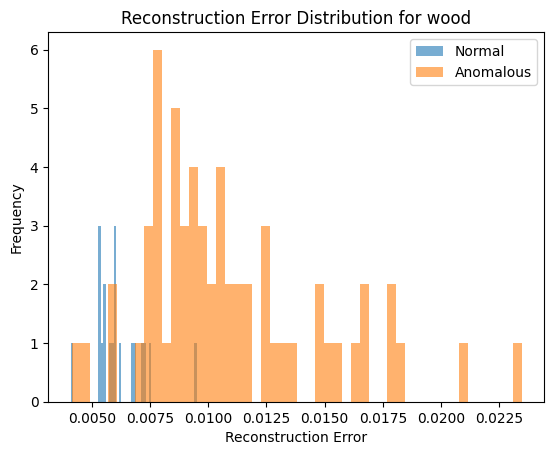

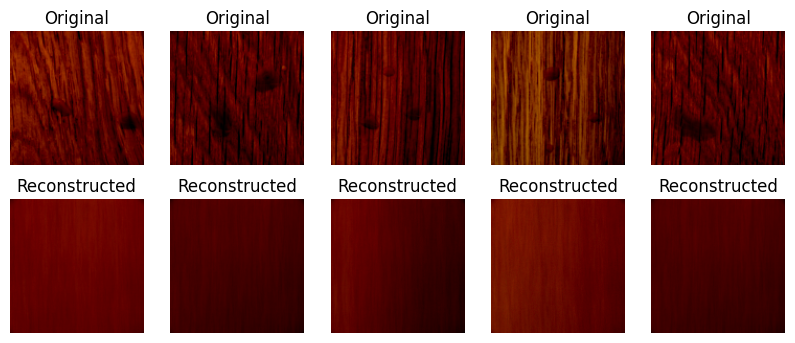

Processing zipper...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.0683
Epoch [2/20], Loss: 0.0304
Epoch [3/20], Loss: 0.0187
Epoch [4/20], Loss: 0.0185
Epoch [5/20], Loss: 0.0143
Epoch [6/20], Loss: 0.0182
Epoch [7/20], Loss: 0.0130
Epoch [8/20], Loss: 0.0174
Epoch [9/20], Loss: 0.0143
Epoch [10/20], Loss: 0.0155
Epoch [11/20], Loss: 0.0124
Epoch [12/20], Loss: 0.0123
Epoch [13/20], Loss: 0.0125
Epoch [14/20], Loss: 0.0124
Epoch [15/20], Loss: 0.0092
Epoch [16/20], Loss: 0.0103
Epoch [17/20], Loss: 0.0093
Epoch [18/20], Loss: 0.0112
Epoch [19/20], Loss: 0.0095
Epoch [20/20], Loss: 0.0121
Best threshold for zipper based on F1 score: 0.0048354738391935825


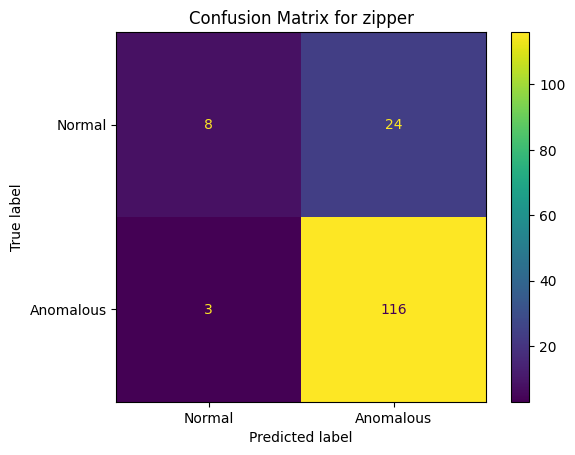

Precision for zipper: 0.8286
Recall for zipper: 0.9748
F1 Score for zipper: 0.8958


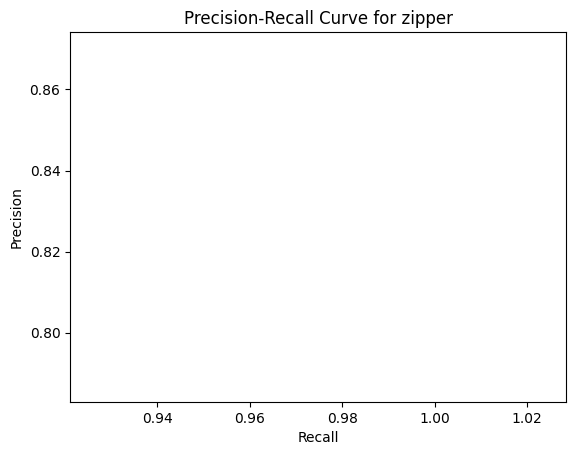

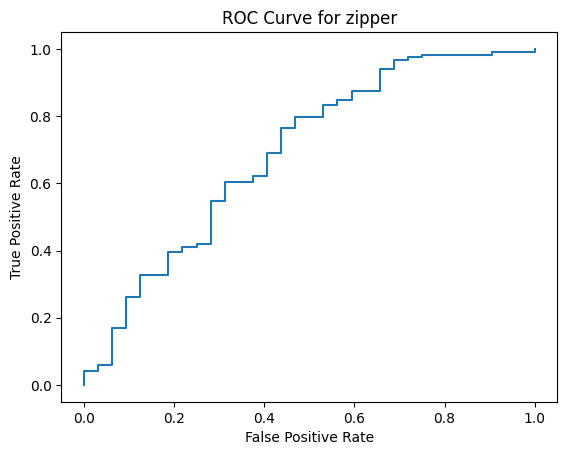

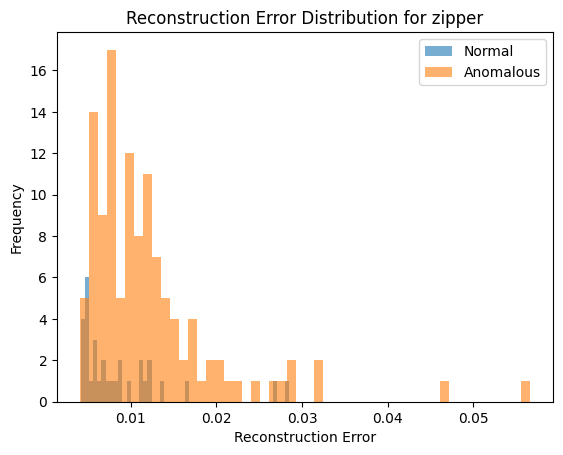

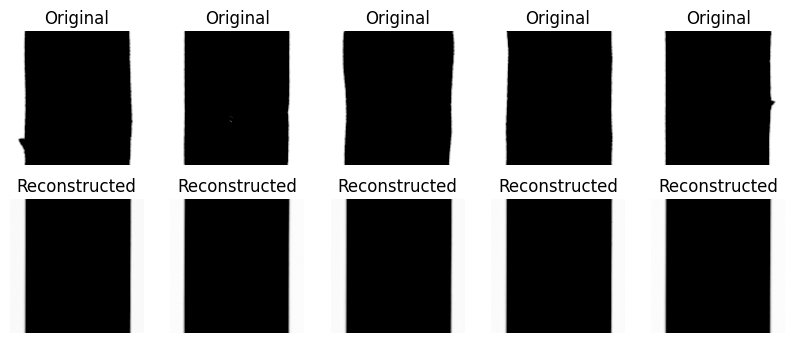

In [5]:

# Define the Autoencoder with ResNet-18 Feature Extraction
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Use ResNet-18 as the feature extractor (encoder)
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Fully connected layers for further encoding
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # Fully connected layers for decoding
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)

        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(512, 128*128*3),
            nn.Tanh()  # or nn.Sigmoid() depending on the input normalization
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the encoder

        # Further encode the features
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))

        # Decode the features
        x = nn.ReLU()(self.fc4(x))
        x = nn.ReLU()(self.fc5(x))
        x = nn.ReLU()(self.fc6(x))

        x = self.decoder(x)
        x = x.view(x.size(0), 3, 128, 128)  # Reshape back to image dimensions
        return x


# Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Directory Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/archive'
object_names = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

# Function for detecting anomalies
def detect_anomaly(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        reconstructed = model(image)
        error = nn.functional.mse_loss(reconstructed, image)
    return error.item()

# Function to show reconstructions
def show_reconstructions(model, dataset, num_images=5):
    model.eval()
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        img, label = dataset[i]
        img = img.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            reconstructed = model(img)

        # Display original image
        axes[0, i].imshow(img.squeeze().permute(1, 2, 0).numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display reconstructed image
        axes[1, i].imshow(reconstructed.squeeze().permute(1, 2, 0).numpy())
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()

# Process each object in the dataset
for object_name in object_names:
    print(f"Processing {object_name}...")

    # Create Data Loaders
    train_dataset = MVTecDataset(root_dir=base_dir, object_name=object_name, transform=transform, train=True)
    test_dataset = MVTecDataset(root_dir=base_dir, object_name=object_name, transform=transform, train=False)
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    # Initialize the Model, Loss, and Optimizer
    model = ResNetAutoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            img, _ = data
            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the Model
    model.eval()
    anomaly_scores = []
    labels = []

    for data in test_loader:
        img, label = data
        for i in range(img.size(0)):
            score = detect_anomaly(model, img[i])
            anomaly_scores.append(score)
            labels.append(label[i].item())

    # Calculate metrics
    precision, recall, thresholds_pr = precision_recall_curve(labels, anomaly_scores)
    fpr, tpr, thresholds_roc = roc_curve(labels, anomaly_scores)

    # Find the threshold where precision and recall are closest
    best_threshold_index = np.argmax(np.abs(precision[:-1] - recall[:-1]))
    best_threshold = thresholds_pr[best_threshold_index]

    # Alternatively, you can choose the threshold to maximize the F1 score
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_threshold_index]

    print(f'Best threshold for {object_name} based on F1 score: {best_threshold}')

    # Convert anomaly scores to binary predictions using the selected threshold
    binary_predictions = [1 if score > best_threshold else 0 for score in anomaly_scores]

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, binary_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
    disp.plot()
    plt.title(f'Confusion Matrix for {object_name}')
    plt.show()

    # Calculate precision, recall, and F1 score
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    f1 = f1_score(labels, binary_predictions)

    print(f'Precision for {object_name}: {precision:.4f}')
    print(f'Recall for {object_name}: {recall:.4f}')
    print(f'F1 Score for {object_name}: {f1:.4f}')

    # Plot Precision-Recall curve
    disp_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp_pr.plot()
    plt.title(f'Precision-Recall Curve for {object_name}')
    plt.show()

    # Plot ROC curve
    disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp_roc.plot()
    plt.title(f'ROC Curve for {object_name}')
    plt.show()

    # Plot Reconstruction Error Distribution
    normal_errors = [anomaly_scores[i] for i in range(len(anomaly_scores)) if labels[i] == 0]
    anomalous_errors = [anomaly_scores[i] for i in range(len(anomaly_scores)) if labels[i] == 1]

    plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal')
    plt.hist(anomalous_errors, bins=50, alpha=0.6, label='Anomalous')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Reconstruction Error Distribution for {object_name}')
    plt.show()

    # Show reconstructions for some samples from the test set
    show_reconstructions(model, test_dataset)

In [ ]:
def detect_anomaly(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        reconstructed = model(image)
        error = nn.functional.mse_loss(reconstructed, image)
    return error.item()

def show_reconstructions(model, dataset, num_images=5):
    model.eval()
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        img, label = dataset[i]
        img = img.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            reconstructed = model(img)

        # Display original image
        axes[0, i].imshow(img.squeeze().permute(1, 2, 0).numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display reconstructed image
        axes[1, i].imshow(reconstructed.squeeze().permute(1, 2, 0).numpy())
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()


# **Combination 1**

Processing bottle...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


Epoch [1/10], Loss: 0.4909
Epoch [2/10], Loss: 0.3568
Epoch [3/10], Loss: 0.0712
Epoch [4/10], Loss: 0.0246
Epoch [5/10], Loss: 0.0123
Epoch [6/10], Loss: 0.0050
Epoch [7/10], Loss: 0.0222
Epoch [8/10], Loss: 0.0040
Epoch [9/10], Loss: 0.0121
Epoch [10/10], Loss: 0.0056
Best threshold for bottle based on F1 score: 0.005582556594163179


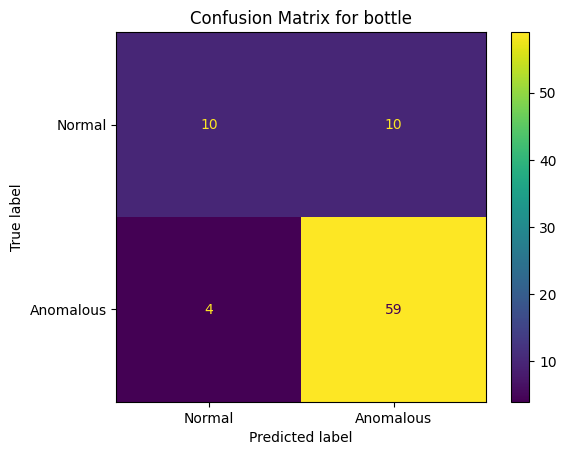

Precision for bottle: 0.8551
Recall for bottle: 0.9365
F1 Score for bottle: 0.8939
Processing cable...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1970
Epoch [2/10], Loss: 0.1663
Epoch [3/10], Loss: 0.0899
Epoch [4/10], Loss: 0.0643
Epoch [5/10], Loss: 0.0596
Epoch [6/10], Loss: 0.0561
Epoch [7/10], Loss: 0.0584
Epoch [8/10], Loss: 0.0561
Epoch [9/10], Loss: 0.0513
Epoch [10/10], Loss: 0.0540
Best threshold for cable based on F1 score: 0.03647520765662193


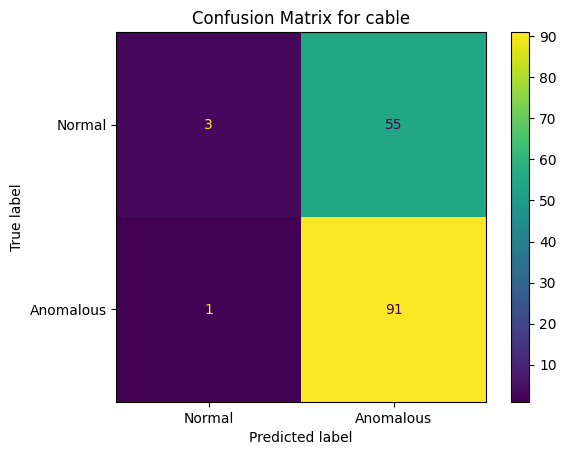

Precision for cable: 0.6233
Recall for cable: 0.9891
F1 Score for cable: 0.7647
Processing capsule...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3539
Epoch [2/10], Loss: 0.2395
Epoch [3/10], Loss: 0.0417
Epoch [4/10], Loss: 0.0092
Epoch [5/10], Loss: 0.0034
Epoch [6/10], Loss: 0.0021
Epoch [7/10], Loss: 0.0013
Epoch [8/10], Loss: 0.0012
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0016
Best threshold for capsule based on F1 score: 0.0004771011881530285


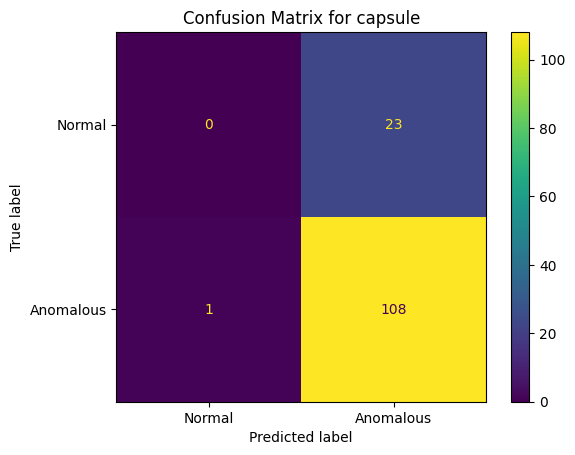

Precision for capsule: 0.8244
Recall for capsule: 0.9908
F1 Score for capsule: 0.9000
Processing carpet...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0953
Epoch [2/10], Loss: 0.0432
Epoch [3/10], Loss: 0.0286
Epoch [4/10], Loss: 0.0269
Epoch [5/10], Loss: 0.0270
Epoch [6/10], Loss: 0.0265
Epoch [7/10], Loss: 0.0259
Epoch [8/10], Loss: 0.0277
Epoch [9/10], Loss: 0.0261
Epoch [10/10], Loss: 0.0272
Best threshold for carpet based on F1 score: 0.02279137633740902


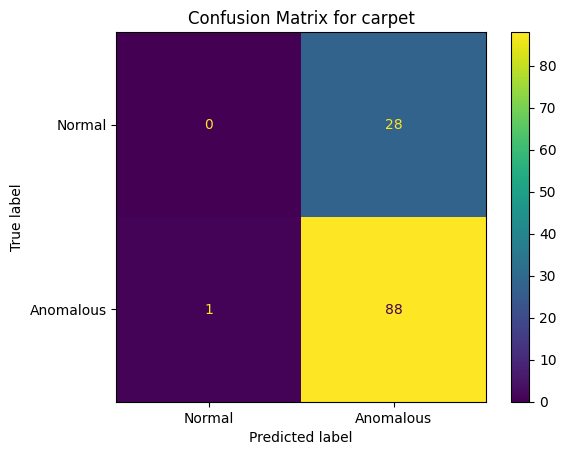

Precision for carpet: 0.7586
Recall for carpet: 0.9888
F1 Score for carpet: 0.8585
Processing grid...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1130
Epoch [2/10], Loss: 0.1007
Epoch [3/10], Loss: 0.0890
Epoch [4/10], Loss: 0.0969
Epoch [5/10], Loss: 0.0938
Epoch [6/10], Loss: 0.1093
Epoch [7/10], Loss: 0.0796
Epoch [8/10], Loss: 0.0660
Epoch [9/10], Loss: 0.0928
Epoch [10/10], Loss: 0.0993
Best threshold for grid based on F1 score: 0.03845665231347084


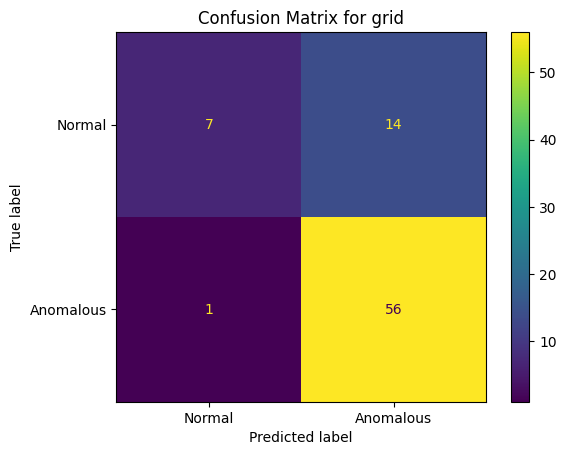

Precision for grid: 0.8000
Recall for grid: 0.9825
F1 Score for grid: 0.8819
Processing hazelnut...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3316
Epoch [2/10], Loss: 0.0431
Epoch [3/10], Loss: 0.0072
Epoch [4/10], Loss: 0.0072
Epoch [5/10], Loss: 0.0099
Epoch [6/10], Loss: 0.0079
Epoch [7/10], Loss: 0.0076
Epoch [8/10], Loss: 0.0067
Epoch [9/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0068
Best threshold for hazelnut based on F1 score: 0.004548388067632914


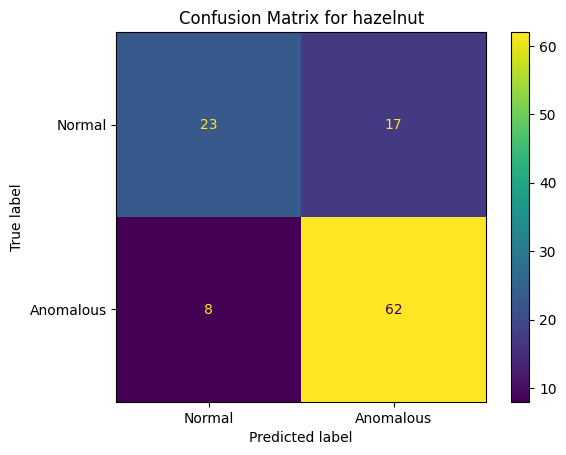

Precision for hazelnut: 0.7848
Recall for hazelnut: 0.8857
F1 Score for hazelnut: 0.8322
Processing leather...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1825
Epoch [2/10], Loss: 0.1137
Epoch [3/10], Loss: 0.0190
Epoch [4/10], Loss: 0.0034
Epoch [5/10], Loss: 0.0023
Epoch [6/10], Loss: 0.0013
Epoch [7/10], Loss: 0.0021
Epoch [8/10], Loss: 0.0016
Epoch [9/10], Loss: 0.0031
Epoch [10/10], Loss: 0.0010
Best threshold for leather based on F1 score: 0.0015605060616508126


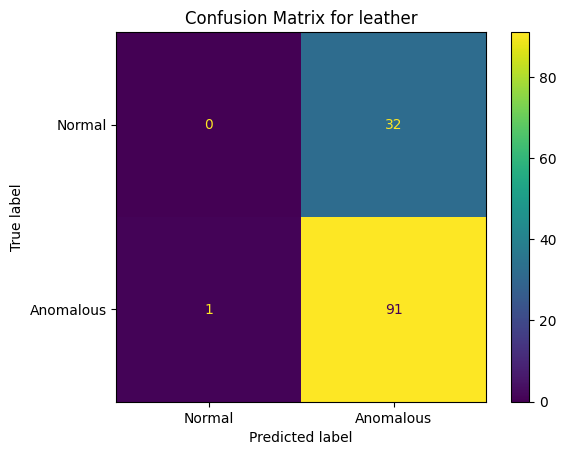

Precision for leather: 0.7398
Recall for leather: 0.9891
F1 Score for leather: 0.8465
Processing metal_nut...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.3816
Epoch [2/10], Loss: 0.2813
Epoch [3/10], Loss: 0.1091
Epoch [4/10], Loss: 0.0471
Epoch [5/10], Loss: 0.0442
Epoch [6/10], Loss: 0.0394
Epoch [7/10], Loss: 0.0375
Epoch [8/10], Loss: 0.0370
Epoch [9/10], Loss: 0.0424
Epoch [10/10], Loss: 0.0392
Best threshold for metal_nut based on F1 score: 0.024320220574736595


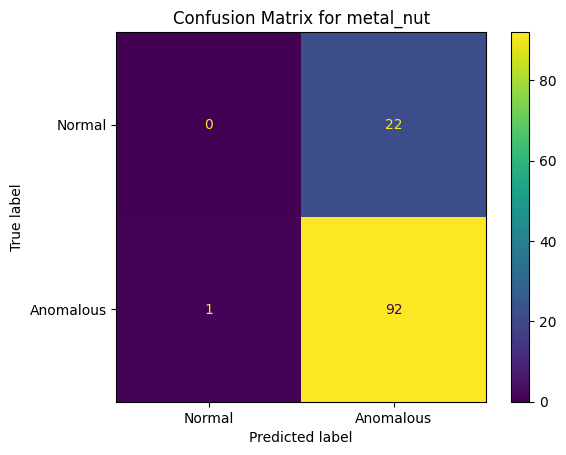

Precision for metal_nut: 0.8070
Recall for metal_nut: 0.9892
F1 Score for metal_nut: 0.8889
Processing pill...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.4581
Epoch [2/10], Loss: 0.2289
Epoch [3/10], Loss: 0.0378
Epoch [4/10], Loss: 0.0063
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0023
Epoch [7/10], Loss: 0.0021
Epoch [8/10], Loss: 0.0020
Epoch [9/10], Loss: 0.0020
Epoch [10/10], Loss: 0.0020
Best threshold for pill based on F1 score: 0.001021844451315701


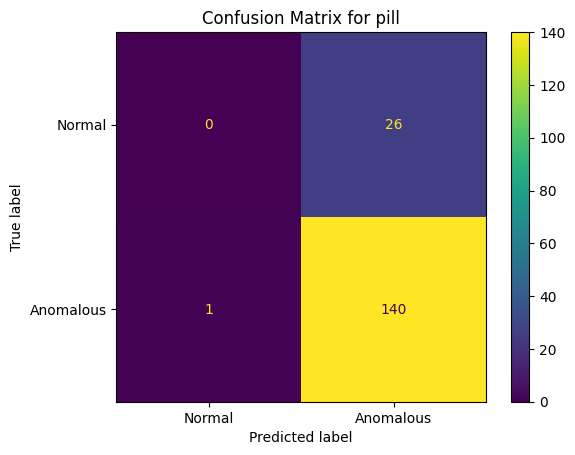

Precision for pill: 0.8434
Recall for pill: 0.9929
F1 Score for pill: 0.9121
Processing screw...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.2397
Epoch [2/10], Loss: 0.0783
Epoch [3/10], Loss: 0.0526
Epoch [4/10], Loss: 0.0469
Epoch [5/10], Loss: 0.0412
Epoch [6/10], Loss: 0.0409
Epoch [7/10], Loss: 0.0331
Epoch [8/10], Loss: 0.0338
Epoch [9/10], Loss: 0.0314
Epoch [10/10], Loss: 0.0276
Best threshold for screw based on F1 score: 0.01062445342540741


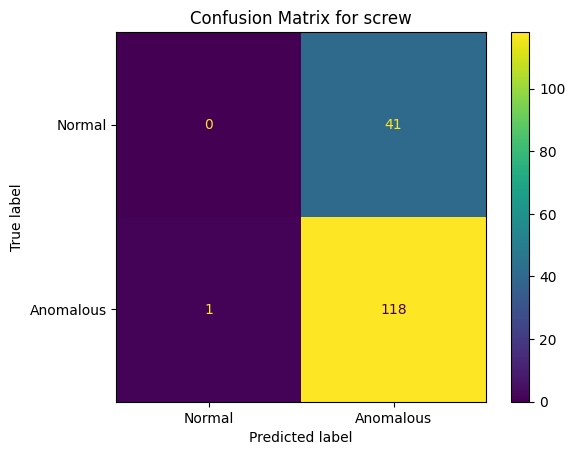

Precision for screw: 0.7421
Recall for screw: 0.9916
F1 Score for screw: 0.8489
Processing tile...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0595
Epoch [2/10], Loss: 0.0610
Epoch [3/10], Loss: 0.0606
Epoch [4/10], Loss: 0.0477
Epoch [5/10], Loss: 0.0551
Epoch [6/10], Loss: 0.0456
Epoch [7/10], Loss: 0.0529
Epoch [8/10], Loss: 0.0529
Epoch [9/10], Loss: 0.0504
Epoch [10/10], Loss: 0.0511
Best threshold for tile based on F1 score: 0.039622772485017776


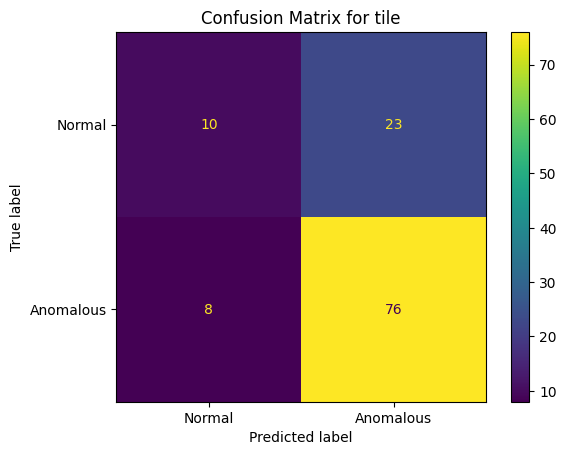

Precision for tile: 0.7677
Recall for tile: 0.9048
F1 Score for tile: 0.8306
Processing toothbrush...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.5576
Epoch [2/10], Loss: 0.5360
Epoch [3/10], Loss: 0.5424
Epoch [4/10], Loss: 0.5194
Epoch [5/10], Loss: 0.5068
Epoch [6/10], Loss: 0.4507
Epoch [7/10], Loss: 0.3834
Epoch [8/10], Loss: 0.3061
Epoch [9/10], Loss: 0.2001
Epoch [10/10], Loss: 0.1166
Best threshold for toothbrush based on F1 score: 0.06529998034238815


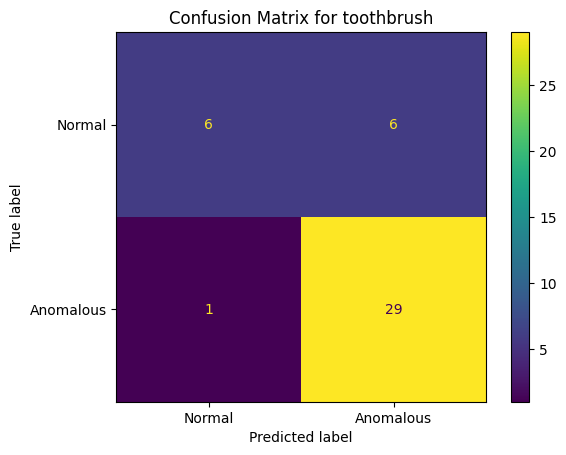

Precision for toothbrush: 0.8286
Recall for toothbrush: 0.9667
F1 Score for toothbrush: 0.8923
Processing transistor...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.2535
Epoch [2/10], Loss: 0.1869
Epoch [3/10], Loss: 0.0602
Epoch [4/10], Loss: 0.0279
Epoch [5/10], Loss: 0.0257
Epoch [6/10], Loss: 0.0236
Epoch [7/10], Loss: 0.0280
Epoch [8/10], Loss: 0.0304
Epoch [9/10], Loss: 0.0299
Epoch [10/10], Loss: 0.0317
Best threshold for transistor based on F1 score: 0.020695079118013382


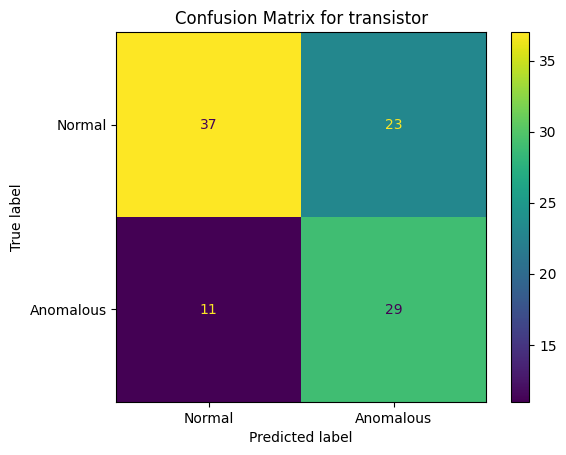

Precision for transistor: 0.5577
Recall for transistor: 0.7250
F1 Score for transistor: 0.6304
Processing wood...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.0727
Epoch [2/10], Loss: 0.0397
Epoch [3/10], Loss: 0.0160
Epoch [4/10], Loss: 0.0141
Epoch [5/10], Loss: 0.0135
Epoch [6/10], Loss: 0.0095
Epoch [7/10], Loss: 0.0139
Epoch [8/10], Loss: 0.0103
Epoch [9/10], Loss: 0.0135
Epoch [10/10], Loss: 0.0117
Best threshold for wood based on F1 score: 0.008596064522862434


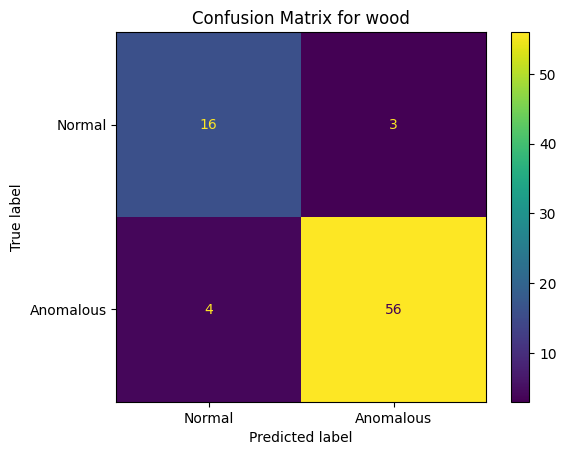

Precision for wood: 0.9492
Recall for wood: 0.9333
F1 Score for wood: 0.9412
Processing zipper...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.4193
Epoch [2/10], Loss: 0.2846
Epoch [3/10], Loss: 0.0679
Epoch [4/10], Loss: 0.0307
Epoch [5/10], Loss: 0.0183
Epoch [6/10], Loss: 0.0159
Epoch [7/10], Loss: 0.0177
Epoch [8/10], Loss: 0.0173
Epoch [9/10], Loss: 0.0127
Epoch [10/10], Loss: 0.0112
Best threshold for zipper based on F1 score: 0.007175732869654894


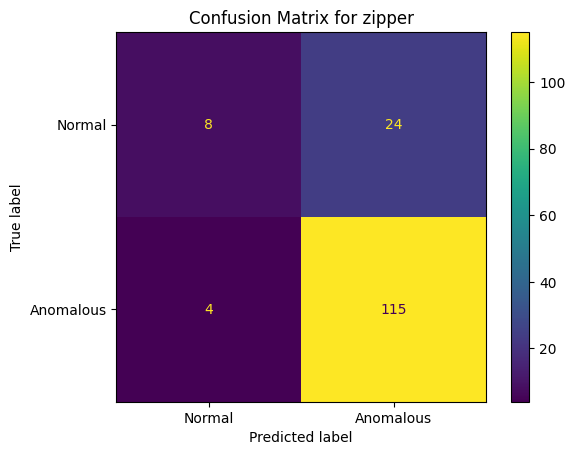

Precision for zipper: 0.8273
Recall for zipper: 0.9664
F1 Score for zipper: 0.8915


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Custom Dataset Class
class MVTecDataset(Dataset):
    def __init__(self, root_dir, object_name, transform=None, train=True):
        self.root_dir = root_dir
        self.object_name = object_name
        self.transform = transform
        self.train = train
        self.image_paths = []
        self.labels = []

        if self.train:
            train_dir = os.path.join(root_dir, object_name, 'train', 'good')
            for img_name in os.listdir(train_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(train_dir, img_name))
                    self.labels.append(0)
        else:
            test_dir = os.path.join(root_dir, object_name, 'test')
            for category in os.listdir(test_dir):
                category_dir = os.path.join(test_dir, category)
                if os.path.isdir(category_dir):
                    label = 0 if category == 'good' else 1
                    for img_name in os.listdir(category_dir):
                        if img_name.endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(os.path.join(category_dir, img_name))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the Autoencoder with ResNet-18 Feature Extraction
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Use ResNet-18 as the feature extractor (encoder)
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Fully connected layers for further encoding
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)

        # Fully connected layers for decoding
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)

        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(512, 128*128*3),
            nn.Tanh()  # or nn.Sigmoid() depending on the input normalization
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the encoder

        # Further encode the features
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))

        # Decode the features
        x = nn.ReLU()(self.fc4(x))
        x = nn.ReLU()(self.fc5(x))
        x = nn.ReLU()(self.fc6(x))

        x = self.decoder(x)
        x = x.view(x.size(0), 3, 128, 128)  # Reshape back to image dimensions
        return x

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Directory Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/archive'
object_names = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

# Function for detecting anomalies
def detect_anomaly(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        reconstructed = model(image)
        error = nn.functional.mse_loss(reconstructed, image)
    return error.item()

# Function to show reconstructions
def show_reconstructions(model, dataset, num_images=5):
    model.eval()
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        img, label = dataset[i]
        img = img.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            reconstructed = model(img)

        # Display original image
        axes[0, i].imshow(img.squeeze().permute(1, 2, 0).numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display reconstructed image
        axes[1, i].imshow(reconstructed.squeeze().permute(1, 2, 0).numpy())
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.show()

# Process each object in the dataset
for object_name in object_names:
    print(f"Processing {object_name}...")

    # Create Data Loaders
    train_dataset = MVTecDataset(root_dir=base_dir, object_name=object_name, transform=transform, train=True)
    test_dataset = MVTecDataset(root_dir=base_dir, object_name=object_name, transform=transform, train=False)
    train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)  # Batch size changed to 16
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    # Initialize the Model, Loss, and Optimizer
    model = ResNetAutoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Learning rate changed to 0.0001

    # Training Loop
    num_epochs = 10  # Number of epochs changed to 10
    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            img, _ = data
            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the Model
    model.eval()
    anomaly_scores = []
    labels = []

    for data in test_loader:
        img, label = data
        for i in range(img.size(0)):
            score = detect_anomaly(model, img[i])
            anomaly_scores.append(score)
            labels.append(label[i].item())

    # Calculate metrics
    precision, recall, thresholds_pr = precision_recall_curve(labels, anomaly_scores)
    fpr, tpr, thresholds_roc = roc_curve(labels, anomaly_scores)

    # Find the threshold where precision and recall are closest
    best_threshold_index = np.argmax(np.abs(precision[:-1] - recall[:-1]))
    best_threshold = thresholds_pr[best_threshold_index]

    # Alternatively, you can choose the threshold to maximize the F1 score
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_threshold_index]

    print(f'Best threshold for {object_name} based on F1 score: {best_threshold}')

    # Convert anomaly scores to binary predictions using the selected threshold
    binary_predictions = [1 if score > best_threshold else 0 for score in anomaly_scores]

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(labels, binary_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomalous'])
    disp.plot()
    plt.title(f'Confusion Matrix for {object_name}')
    plt.show()

    # Calculate precision, recall, and F1 score
    precision = precision_score(labels, binary_predictions)
    recall = recall_score(labels, binary_predictions)
    f1 = f1_score(labels, binary_predictions)

    print(f'Precision for {object_name}: {precision:.4f}')
    print(f'Recall for {object_name}: {recall:.4f}')
    print(f'F1 Score for {object_name}: {f1:.4f}')

In [ ]:
# Plot Precision-Recall curve
disp_pr = PrecisionRecallDisplay(precision=precision, recall=recall)
disp_pr.plot()
plt.title(f'Precision-Recall Curve for {object_name}')
plt.show()

# Plot ROC curve
disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
disp_roc.plot()
plt.title(f'ROC Curve for {object_name}')
plt.show()

# Plot Reconstruction Error Distribution
normal_errors = [anomaly_scores[i] for i in range(len(anomaly_scores)) if labels[i] == 0]
anomalous_errors = [anomaly_scores[i] for i in range(len(anomaly_scores)) if labels[i] == 1]

plt.hist(normal_errors, bins=50, alpha=0.6, label='Normal')
plt.hist(anomalous_errors, bins=50, alpha=0.6, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Reconstruction Error Distribution for {object_name}')
plt.show()

# Show reconstructions for some samples from the test set
show_reconstructions(model, test_dataset)
